In [1]:
%matplotlib inline

In [2]:
#__ = plt.style.use("./diffstar.mplstyle")
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac

In [3]:
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
import os
import h5py
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]


In [4]:
from diffstar.utils import _get_dt_array, jax_np_interp
from diffstar.fit_smah_helpers import get_header, load_diffstar_data
from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    compute_fstar,
    compute_fstar_vmap,
    _sfr_eff_plaw,
    _get_bounded_sfr_params, 
    _get_unbounded_sfr_params,
    _get_unbounded_sfr_params_vmap,
    _get_bounded_sfr_params_vmap,
    calculate_histories,
    calculate_histories_vmap,
    calculate_histories_batch,
    fstar_tools,
)
from diffstar.constants import TODAY

from diffstar.quenching import _get_bounded_q_params, _get_unbounded_q_params, _get_bounded_q_params_vmap, _get_unbounded_q_params_vmap
from diffmah.individual_halo_assembly import _calc_halo_history

from chainconsumer import ChainConsumer

def calculate_fstar_data_batch(tarr, sm_cumsum, index_select, index_high, fstar_tdelay):
    ng = len(sm_cumsum)
    nt = len(index_high)
    fstar = np.zeros((ng,nt))
    indices = np.array_split(np.arange(ng), int(ng/5000))
    for inds in indices:
        fstar[inds] = compute_fstar_vmap(tarr, sm_cumsum[inds], index_select, index_high, fstar_tdelay)
    return fstar
    
def _calculate_sm(lgt, dt, mah_params, sfr_params, q_params, index_select, index_high, fstar_tdelay):
    dmhdt, log_mah = _calc_halo_history(lgt, *mah_params)
    mstar, sfr, fstar = calculate_sm_sfr_fstar_history_from_mah(
        lgt, dt, dmhdt, log_mah, sfr_params, q_params,
        index_select,
        index_high,
        fstar_tdelay
    )
    return mstar, sfr, fstar, dmhdt, log_mah



calculate_sm = jjit(vmap(_calculate_sm, in_axes=(None, None, 0, 0, 0, None, None, None)))

colnames = get_header()[1:].strip().split()
sfr_colnames = colnames[1:6]
q_colnames = colnames[6:10]


/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


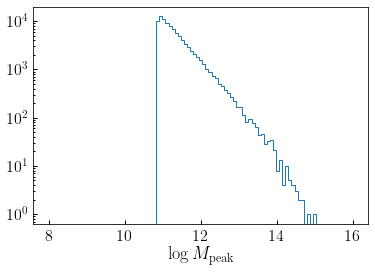

In [5]:
from astropy.cosmology import Planck15



data_path = "/Users/alarcon/Documents/diffmah_data/"
results_path = data_path

halos_SMDPL = np.load(data_path+'SMDPL_subvol0..9.npz')
SMDPL_a = np.load(data_path+"scale_list_SMDPL.npy")
SMDPL_z = 1.0 / SMDPL_a - 1.0
SMDPL_t = Planck15.age(SMDPL_z).value

dt_SMDPL = _get_dt_array(SMDPL_t)

H_SMDPL = 0.6777
# From https://www.cosmosim.org/cms/simulations/smdpl/
# The mass particle resolution is 9.63e7 Msun/h
particle_mass_res = 9.63e7 / H_SMDPL
# So we cut halos with M0 below 500 times the mass resolution.
logmpeak_fit_min = np.log10(500 * particle_mass_res)

sm_cumsum_SMDPL = np.cumsum(halos_SMDPL['sfr_history_main_prog']*dt_SMDPL,axis=1)*1e9
mhalo_SMDPL = np.maximum.accumulate(halos_SMDPL["mpeak_history_main_prog"], axis=1)
logmpeak_SMDPL = np.log10(mhalo_SMDPL[:, -1])
sfrh_SMDPL = halos_SMDPL['sfr_history_main_prog']
sSFR_SMDPL = halos_SMDPL["sfr_history_main_prog"] / sm_cumsum_SMDPL

sel = logmpeak_SMDPL >= logmpeak_fit_min

sm_cumsum_SMDPL = sm_cumsum_SMDPL[sel]
mhalo_SMDPL = mhalo_SMDPL[sel]
logmpeak_SMDPL = logmpeak_SMDPL[sel]
sfrh_SMDPL = sfrh_SMDPL[sel]
sSFR_SMDPL = sSFR_SMDPL[sel]


_bins = np.linspace(8,16,100)
plt.hist(logmpeak_SMDPL, bins=_bins, histtype='step')
plt.xlabel(r'$\log M_{\rm{peak}}$')
plt.yscale('log')
plt.show()


def get_mah_params(runname1):
    
    fitting_data = dict()

    fn = f"{data_path}{runname1}"
    with h5py.File(fn, 'r') as hdf:
        for key in hdf.keys():
            if key == 'halo_id':
                fitting_data[key] = hdf[key][...]
            else:
                fitting_data['fit_'+key] = hdf[key][...]
                
    mah_params = np.array([
        np.log10(fitting_data['fit_t0']),
        fitting_data['fit_logmp_fit'],
        fitting_data['fit_mah_logtc'],
        fitting_data['fit_mah_k'],
        fitting_data['fit_early_index'],
        fitting_data['fit_late_index'], 
    ]).T
    return mah_params
            
            
mah_params_SMDPL_arr = []  
for i in range(10):
    runname1 = "run1_SMDPL_diffmah_default_%d.h5"%i
    mah_params_SMDPL_arr.append(get_mah_params(runname1))
    
mah_params_SMDPL = np.concatenate(mah_params_SMDPL_arr, axis=0)

            
            
fstar_tdelay = 1.0
index_select_SMDPL, fstar_indx_high_SMDPL = fstar_tools(SMDPL_t, fstar_tdelay)

lgt_SMDPL = np.log10(SMDPL_t)


fstar_data_SMDPL = calculate_fstar_data_batch(SMDPL_t, sm_cumsum_SMDPL, index_select_SMDPL, fstar_indx_high_SMDPL, fstar_tdelay)

In [6]:
def get_multiple_diffstar_res():
    mstar_arr = []
    sfr_arr = []
    fstar_arr = []
    dmhdt_arr = []
    log_mah_arr = []
    fit_params_arr = []
    u_fit_params_arr = []
    loss_arr = []
    success_arr = []

    _res_SMDPL = []
    for i in range(10):
        runname1 = "run1_SMDPL_diffstar_default_%i.h5"%i
        _res_SMDPL = load_diffstar_data(runname1, SMDPL_t, fstar_tdelay, mah_params_SMDPL_arr[i], results_path)

        mstar_arr.append(_res_SMDPL[0][0])
        sfr_arr.append(_res_SMDPL[0][1])
        fstar_arr.append(_res_SMDPL[0][2])
        dmhdt_arr.append(_res_SMDPL[0][3])
        log_mah_arr.append(_res_SMDPL[0][4])
        fit_params_arr.append(_res_SMDPL[1])
        u_fit_params_arr.append(_res_SMDPL[2])
        loss_arr.append(_res_SMDPL[3])
        success_arr.append(_res_SMDPL[4])

    mstar_arr = np.concatenate(mstar_arr, axis=0)
    sfr_arr = np.concatenate(sfr_arr, axis=0)
    fstar_arr = np.concatenate(fstar_arr, axis=0)
    dmhdt_arr = np.concatenate(dmhdt_arr, axis=0)
    log_mah_arr = np.concatenate(log_mah_arr, axis=0)
    fit_params_arr = np.concatenate(fit_params_arr, axis=0)
    u_fit_params_arr = np.concatenate(u_fit_params_arr, axis=0)
    loss_arr = np.concatenate(loss_arr, axis=0)
    success_arr = np.concatenate(success_arr, axis=0)

    res = (
        (
            mstar_arr,
            sfr_arr,
            fstar_arr,
            dmhdt_arr,
            log_mah_arr,
        ),
        fit_params_arr,
        u_fit_params_arr,
        loss_arr,
        success_arr
    )

    return res

res_SMDPL = get_multiple_diffstar_res()

(9498, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  10, 9488]))
(9092, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9087]))
(9081, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   8, 9073]))
(9242, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9237]))
(9333, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   5, 9328]))
(9408, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   4, 9404]))
(9217, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   2, 9215]))
(9179, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([   6, 9173]))
(9652, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9638]))
(9657, 117) (array(['Fail', 'L-BFGS-B'], dtype='<U8'), array([  14, 9643]))


/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


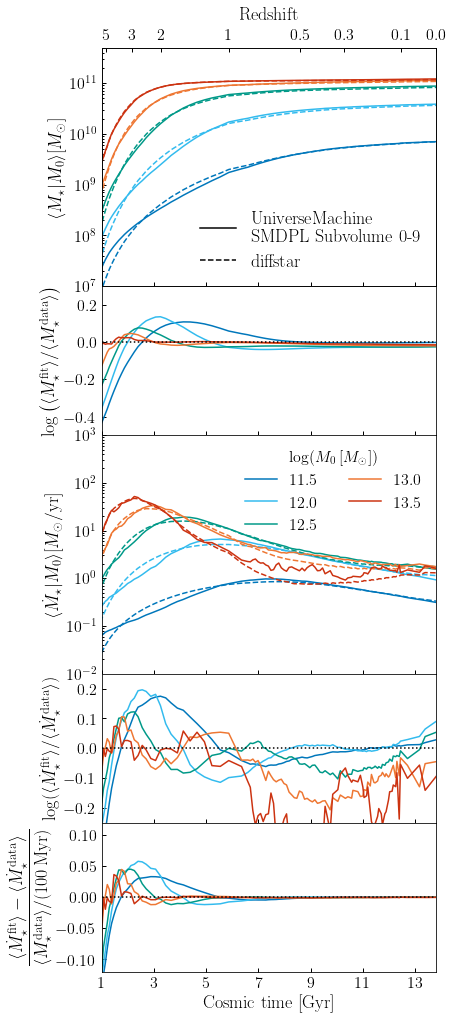

In [7]:
import warnings
fig, ax = plt.subplots(5,1, figsize=(6,17), gridspec_kw={'height_ratios': [1.6, 1, 1.6, 1, 1], 'hspace':0}, sharex=True)

colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']

#mpeak_bins = np.arange(11.0,14.1,0.50)
mpeak_bins = np.arange(11.25,14.0,0.50)


tarr = SMDPL_t
logmpeak = logmpeak_SMDPL
sfrh = sfrh_SMDPL
sm_cumsum = sm_cumsum_SMDPL
fstar_data = fstar_data_SMDPL
mstars_fit, sfrs_fit, fstars_fit = res_SMDPL[0][:3]
index_select = index_select_SMDPL

ssfrh = sfrh / sm_cumsum
ssfrh_fit = sfrs_fit / mstars_fit
ssfrh = np.clip(ssfrh, 1e-12, np.inf)
ssfrh_fit = np.clip(ssfrh_fit, 1e-12, np.inf)
sfrh = np.where(sm_cumsum > 0.0, ssfrh * sm_cumsum, sfrh)
sfrs_fit = ssfrh_fit * mstars_fit

for i in range(len(mpeak_bins)-1):
    masksel = (logmpeak>mpeak_bins[i])&(logmpeak<mpeak_bins[i+1]) 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        mstar_data_mean = np.mean(sm_cumsum[masksel],axis=0)
        mstar_fit_mean = np.mean(mstars_fit[masksel],axis=0)

        ax[0].plot(tarr, mstar_data_mean, color=colors[i])
        ax[0].plot(tarr, mstar_fit_mean, color=colors[i], ls='--')


        smh = sm_cumsum[masksel]
        _mask = np.log10(smh)[:,[-1]]-np.log10(smh) < 3.5
        _mask &= np.log10(smh) > 7.0

        diff_smh = np.log10(mstars_fit[masksel])-np.log10(smh)
        diff_smh = np.where(_mask, diff_smh, np.nan)
        diff_smh = np.where(smh==0, np.nan, diff_smh)
        diff_smh_avg = np.nanmean(diff_smh,axis=0)  
        
        
        diff_smh_avg = np.log10(mstar_fit_mean) - np.log10(mstar_data_mean)
        ax[1].plot(tarr, diff_smh_avg, color=colors[i])

        sfr_data_mean = np.mean(sfrh[masksel],axis=0)                             
        sfr_fit_mean = np.mean(sfrs_fit[masksel],axis=0) 

        ax[2].plot(tarr, sfr_data_mean, color=colors[i])
        ax[2].plot(tarr, sfr_fit_mean, color=colors[i], ls='--')


        diff_smh_avg = np.log10(sfr_fit_mean) - np.log10(sfr_data_mean)
        ax[3].plot(tarr, diff_smh_avg, color=colors[i])

        diff_ssfh_avg = 1e8 * (sfr_fit_mean - sfr_data_mean) / mstar_data_mean

        ax[4].plot(tarr, diff_ssfh_avg, color=colors[i])

    
fontsize=18 
ax[0].set_yscale('log')
ax[0].set_ylim(1e7, 5e11)
ax[0].set_ylabel(r'$\langle M_\star | M_0 \rangle [M_{\odot}]$', fontsize=fontsize)

ax[1].set_ylim(-0.5, 0.30)
ax[1].set_yticks(np.arange(-0.4, 0.25, 0.2))
ax[1].set_ylabel(r"$\log \left( \langle M^{\rm fit}_\star\rangle / \langle M^{\rm data}_\star \rangle \right) $")

ax[1].axhline(0.0, color='k', ls=':')

ax[2].set_yscale('log')
ax[2].set_ylabel(r'$\langle \dot{M}_\star | M_0 \rangle [M_{\odot}/{\rm yr}]$', fontsize=fontsize)
ax[2].set_ylim(1e-2,1e3)




ax[3].set_ylim(-0.25, 0.25)
ax[3].set_yticks(np.arange(-0.2, 0.21, 0.1))
ax[3].set_ylabel(r"$\log ( \langle \dot{M}^{\rm fit}_\star\rangle / \langle \dot{M}^{\rm data}_\star \rangle ) $")

ax[3].axhline(0.0, color='k', ls=':')
ax[3].set_xticks(np.arange(1.0, 14.0, 2.0))

ax[4].axhline(0.0, color='k', ls=':')
ax[4].set_ylim(-0.12, 0.12)
ax[4].set_yticks(np.arange(-0.1, 0.11, 0.05))

ax[4].set_ylabel(r"$\dfrac{\langle \dot{M}^{\rm fit}_\star\rangle - \langle \dot{M}^{\rm data}_\star \rangle}{\langle M^{\rm data}_\star \rangle / (100\,{\rm Myr})} $")
ax[4].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
ax[4].set_xlim(1.0, TODAY)
ax[4].set_xticks(np.arange(1.0, 14.0, 2.0))


colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#AA4499', '#882255']

mpeak_bins = np.arange(11.5,14,0.50)

legend_elements = [
    Line2D([0], [0], color='k', ls='-', label='UniverseMachine \n SMDPL Subvolume 0-9'),
    Line2D([0], [0], color='k', ls='--', label='diffstar'),
           ]

legend1 = ax[0].legend(handles=legend_elements, loc=4, ncol=1, fontsize=18)



legend_elements = []
for i in range(len(mpeak_bins)):
    legend_elements.append(
        Line2D([0], [0], color=colors[i], 
               #label=r'$[%.1f, %.1f]$'%(mpeak_bins[i],mpeak_bins[i+1]))
               #label=r'$M_0=10^{%.1f}\,M_\odot$'%(mpeak_bins[i]))
               label=r'$%.1f$'%(mpeak_bins[i]))
        )

ax[2].legend(handles=legend_elements, loc=1, ncol=2, fontsize=16, title_fontsize=16 ,
             title="$\log (M_0\,[M_\odot])$")

xlim = ax[0].set_xlim()
ax2 = ax[0].twiny()
ax2.set_xlim(xlim[0], xlim[1])
ax2.plot([],[])

ticks_z = np.array([0, 0.1, 0.3, 0.5, 1, 2, 3, 5])
ticks_t = np.array(Planck15.age(ticks_z))
ax[0].set_xticks(np.arange(1.0, 14.0, 2.0))

ax2.set_xticks(ticks_t)
ax2.set_xticklabels([r"$%.1f$"%x if x<1 else r"$%d$"%x  for x in ticks_z ])
ax2.set_xlabel(r'Redshift')
ax2.xaxis.set_label_coords(0.5, 1.12)

#fig.savefig('average_histories_w_residuals_SMDPL_subvol0.png', bbox_inches='tight', dpi=300)
#fig.savefig('average_histories_w_residuals_SMDPL_subvol0.pdf', bbox_inches='tight')



In [39]:
from scipy.signal import peak_widths
from scipy.stats import norm

def calculat_stats_and_errs(params, N=50):
    median = np.median(params, axis=0)
    # sigma = np.std(params, axis=0)
    sigma = np.diff(np.percentile(params, [50-68.27/2.0, 50+68.27/2.0], axis=0), axis=0)/2.0
    
    corr = np.corrcoef(params.T)
    medians_err = []
    sigmas_err = []
    corrs_err = []
    for i in range(N):
        choice = np.random.choice(len(params), len(params), replace=True)
        medians_err.append(np.median(params[choice], axis=0))
        # sigmas_err.append(np.std(params[choice], axis=0, ddof=1))
        sigmas_err.append(np.diff(np.percentile(params[choice], [50-68.27/2.0, 50+68.27/2.0], axis=0), axis=0)/2.0)
        corrs_err.append(np.corrcoef(params[choice].T))
    medians_err = np.std(medians_err, axis=0, ddof=1)
    sigmas_err = np.std(sigmas_err, axis=0, ddof=1)
    corrs_err = np.std(corrs_err, axis=0, ddof=1)
    return median, sigma, corr, medians_err, sigmas_err, corrs_err

def calculat_stats_and_errs_FWHM(params, N=50):
    median = np.median(params, axis=0)    
    corr = np.corrcoef(params.T)
    sigma = np.zeros_like(median)
    _sigmas = np.diff(np.percentile(params, [50-68.27/2.0, 50+68.27/2.0], axis=0), axis=0)[0]/2.0

    for i in range(9):
        if i==3:continue
        params = u_fit_params[mask_mass, i].copy()
        _bins = np.linspace(median[i]-5*_sigmas[i],median[i]+5*_sigmas[i],100)
        _binsc = 0.5*(_bins[1:]+_bins[:-1])
        _vals = np.histogram(params, _bins)[0]
        peak_ind = np.atleast_1d(np.argmax(_vals))
        _peak_width = np.diff(_bins)[0] * peak_widths(_vals, peak_ind, rel_height=0.5)[0] / 2.0
        fraction_within_FWHM = np.sum((median[i] - _peak_width < params) & (params < median[i] + _peak_width)) / len(params)
        if i!=1:
            sigma[i] = _peak_width * 0.68 / fraction_within_FWHM 
        else:
            sigma[i] = _peak_width
    
    medians_err = []
    sigmas_err = []
    corrs_err = []
    for i in range(N):
        choice = np.random.choice(len(params), len(params), replace=True)
        medians_err.append(np.median(params[choice], axis=0))
        # sigmas_err.append(np.std(params[choice], axis=0, ddof=1))
        sigmas_err.append(np.diff(np.percentile(params[choice], [50-68.27/2.0, 50+68.27/2.0], axis=0), axis=0)/2.0)
        corrs_err.append(np.corrcoef(params[choice].T))
    medians_err = np.std(medians_err, axis=0, ddof=1)
    sigmas_err = np.std(sigmas_err, axis=0, ddof=1)
    corrs_err = np.std(corrs_err, axis=0, ddof=1)
    return median, sigma, corr, medians_err, sigmas_err, corrs_err


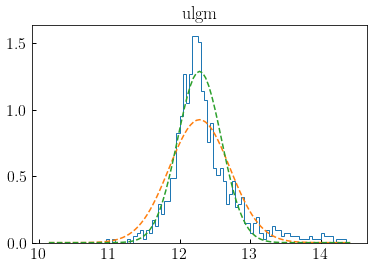

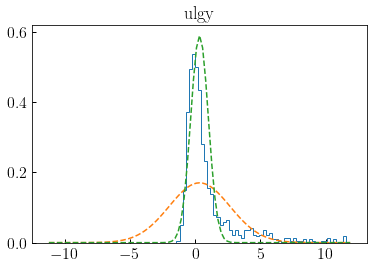

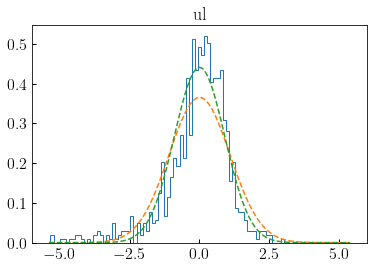

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:17: PeakPropertyWarning: some peaks have a prominence of 0
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:17: PeakPropertyWarning: some peaks have a width of 0
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid valu

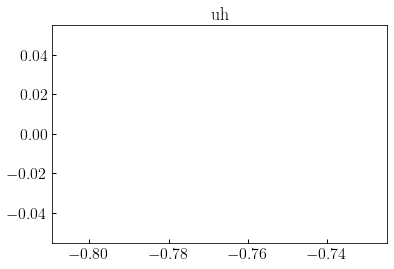

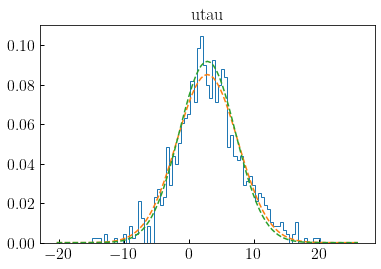

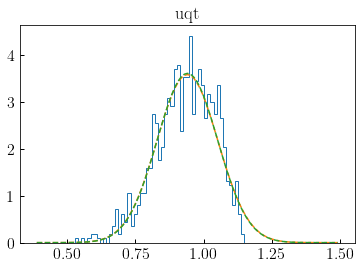

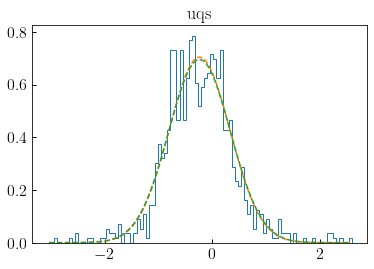

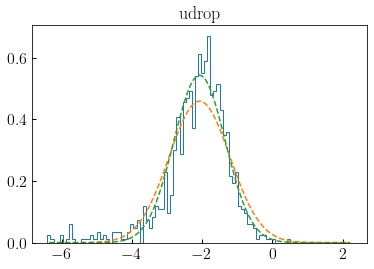

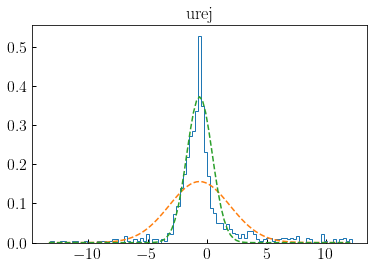

In [31]:
from scipy.signal import peak_widths
from scipy.stats import norm

masslow, masshigh = 12.4, 12.6
mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))

_medians = np.median(u_fit_params[mask_mass, :], axis=0)
_sigmas = np.diff(np.percentile(u_fit_params[mask_mass, :], [50-68.27/2.0, 50+68.27/2.0], axis=0), axis=0)[0]/2.0

for i in range(9):
    params = u_fit_params[mask_mass, i].copy()
    _bins = np.linspace(_medians[i]-5*_sigmas[i],_medians[i]+5*_sigmas[i],100)
    _binsc = 0.5*(_bins[1:]+_bins[:-1])
    _vals = np.histogram(params, _bins)[0]
    peak_ind = np.atleast_1d(np.argmax(_vals))
    _peak_width = np.diff(_bins)[0] * peak_widths(_vals, peak_ind, rel_height=0.5)[0] / 2.0
    fraction_within_FWHM = np.sum((_medians[i] - _peak_width < params) & (params < _medians[i] + _peak_width)) / len(params)
    #_peak_width = _peak_width * 0.68 / fraction_within_FWHM 
    if i!=1:
        _peak_width = _peak_width * 0.68 / fraction_within_FWHM 
    else:
        _peak_width = _peak_width
                  
    plt.hist(params, _bins, density=1, histtype='step');
    plt.plot(_binsc, norm.pdf(_binsc, _medians[i], _sigmas[i]), ls='--')
    plt.plot(_binsc, norm.pdf(_binsc, _medians[i], _peak_width), ls='--')
    plt.title(names[i])
    plt.show()
    #break

In [132]:
fraction_within_FWHM

0.4816285998013903

In [42]:
logmpeak = logmpeak_SMDPL
fit_params = res_SMDPL[1].copy()
u_fit_params = res_SMDPL[2].copy()

massvals = np.arange(11.2, 13.99, 0.1)
massvalsc = 0.5*(massvals[1:]+massvals[:-1])

_free_params = np.array([0, 1, 2, 4, 5, 6, 7, 8])
_ms_params = np.array([0, 1, 2, 4])
_fixed_params = np.array([3,])

medians = np.zeros((len(massvals)-1,9)) + np.nan
medians_Q = np.zeros((len(massvals)-1,9)) + np.nan
medians_MS = np.zeros((len(massvals)-1,9)) + np.nan

sigmas = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_Q = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_MS = np.zeros((len(massvals)-1,9)) + np.nan

corrs = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_Q = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_MS = np.zeros((len(massvals)-1,9,9)) + np.nan

medians_err = np.zeros((len(massvals)-1,9)) + np.nan
medians_err_Q = np.zeros((len(massvals)-1,9)) + np.nan
medians_err_MS = np.zeros((len(massvals)-1,9)) + np.nan

sigmas_err = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_err_Q = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_err_MS = np.zeros((len(massvals)-1,9)) + np.nan

corrs_err = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_err_Q = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_err_MS = np.zeros((len(massvals)-1,9,9)) + np.nan

fquench = np.zeros(len(massvalsc))

for i in range(len(massvals)-1):
    
    masslow, masshigh = massvals[i],massvals[i+1]
    mask_mass = (logmpeak>masslow)&((logmpeak<masshigh)) 
    quenched = (10**res_SMDPL[1][:, 5] <= TODAY)
    
    fquench[i] = quenched[mask_mass].sum()/len(quenched[mask_mass])

    _val = u_fit_params[mask_mass]
    if len(_val) > 0:
        _res = calculat_stats_and_errs_FWHM(u_fit_params[mask_mass])
        medians[i] = _res[0]
        sigmas[i] = _res[1]
        corrs[i] = _res[2]
        medians_err[i] = _res[3]
        sigmas_err[i] = _res[4]
        corrs_err[i] = _res[5]

    _val = u_fit_params[mask_mass&quenched]
    if len(_val) > 0:
        _res = calculat_stats_and_errs_FWHM(_val)
        medians_Q[i] = _res[0]
        sigmas_Q[i] = _res[1]
        corrs_Q[i] = _res[2]
        medians_err_Q[i] = _res[3]
        sigmas_err_Q[i] = _res[4]
        corrs_err_Q[i] = _res[5]

    _val = u_fit_params[mask_mass&~quenched]
    if len(_val) > 0:
        _res = calculat_stats_and_errs_FWHM(_val)
        medians_MS[i] = _res[0]
        sigmas_MS[i] = _res[1]
        corrs_MS[i] = _res[2]
        medians_err_MS[i] = _res[3]
        sigmas_err_MS[i] = _res[4]
        corrs_err_MS[i] = _res[5]

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:37: PeakPropertyWarning: some peaks have a prominence of 0
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:37: PeakPropertyWarning: some peaks have a width of 0
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


logmpeak = logmpeak_SMDPL
fit_params = res_SMDPL[1].copy()
u_fit_params = res_SMDPL[2].copy()

massvals = np.arange(11.2, 13.99, 0.1)
massvalsc = 0.5*(massvals[1:]+massvals[:-1])

_free_params = np.array([0, 1, 2, 4, 5, 6, 7, 8])
_fixed_params = np.array([3,])

medians = np.zeros((len(massvals)-1,9)) + np.nan
medians_Q = np.zeros((len(massvals)-1,9)) + np.nan
medians_MS = np.zeros((len(massvals)-1,9)) + np.nan

sigmas = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_Q = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_MS = np.zeros((len(massvals)-1,9)) + np.nan

corrs = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_Q = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_MS = np.zeros((len(massvals)-1,9,9)) + np.nan

medians_err = np.zeros((len(massvals)-1,9)) + np.nan
medians_err_Q = np.zeros((len(massvals)-1,9)) + np.nan
medians_err_MS = np.zeros((len(massvals)-1,9)) + np.nan

sigmas_err = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_err_Q = np.zeros((len(massvals)-1,9)) + np.nan
sigmas_err_MS = np.zeros((len(massvals)-1,9)) + np.nan

corrs_err = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_err_Q = np.zeros((len(massvals)-1,9,9)) + np.nan
corrs_err_MS = np.zeros((len(massvals)-1,9,9)) + np.nan

fquench = np.zeros(len(massvalsc))

for i in range(len(massvals)-1):
    
    masslow, masshigh = massvals[i],massvals[i+1]
    mask_mass = (logmpeak>masslow)&((logmpeak<masshigh)) 
    quenched = (10**res_SMDPL[1][:, 5] <= TODAY)
    
    fquench[i] = quenched[mask_mass].sum()/len(quenched[mask_mass])

    
    medians[i] = np.median(u_fit_params[mask_mass],axis=0)
    medians_Q[i] = np.median(u_fit_params[mask_mass&quenched],axis=0)
    medians_MS[i] = np.median(u_fit_params[mask_mass&~quenched],axis=0)
    
    sigmas[i] = np.std(u_fit_params[mask_mass],axis=0, ddof=1)
    sigmas_Q[i] = np.std(u_fit_params[mask_mass&quenched],axis=0, ddof=1)
    sigmas_MS[i] = np.std(u_fit_params[mask_mass&~quenched],axis=0, ddof=1)    
    
    corrs[i] = np.corrcoef(u_fit_params[mask_mass].T)
    corrs_Q[i] = np.corrcoef(u_fit_params[mask_mass&quenched].T)
    corrs_MS[i] = np.corrcoef(u_fit_params[mask_mass&~quenched].T)
    
    """
    medians[i] = np.median(fit_params[mask_mass],axis=0)
    medians_Q[i] = np.median(fit_params[mask_mass&quenched],axis=0)
    medians_MS[i] = np.median(fit_params[mask_mass&~quenched],axis=0)
    """

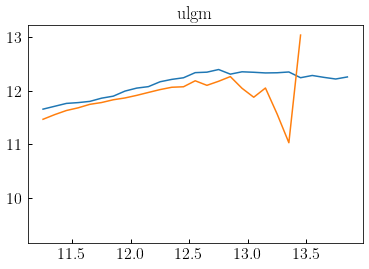

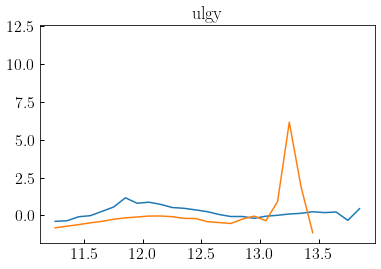

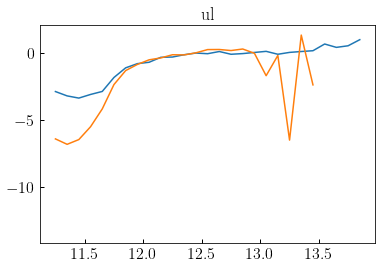

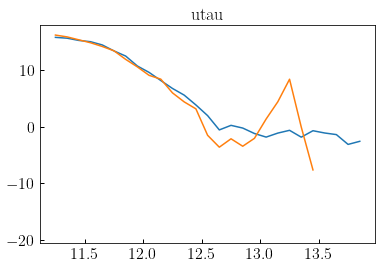

In [12]:

for i in _free_params[:4]:
    #plt.errorbar(massvalsc, medians_Q[:,i], yerr=medians_err_Q[:,i])
    #plt.errorbar(massvalsc, medians_MS[:,i], yerr=medians_err_MS[:,i])
    plt.plot(massvalsc, medians_Q[:,i])
    plt.plot(massvalsc, medians_MS[:,i])
    plt.title(names[i])
    plt.show()

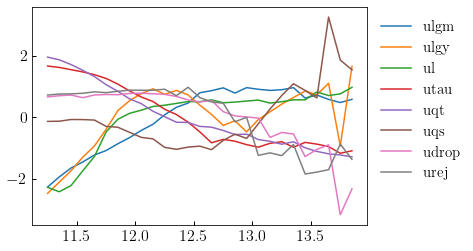

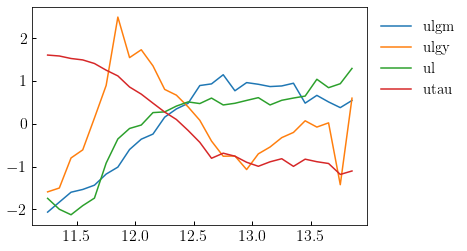

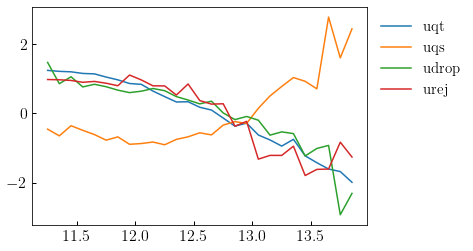

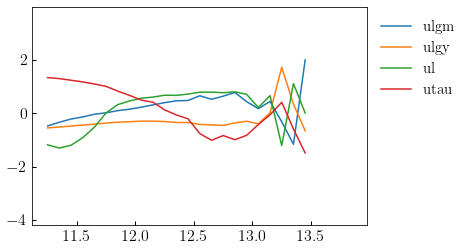

(0.0, 1.0)

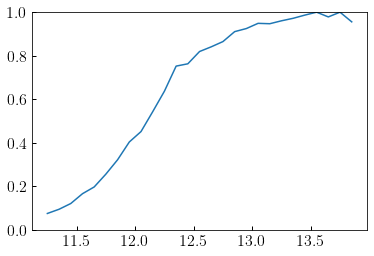

In [12]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]
for i in _free_params:
    # plt.plot(massvalsc, medians[:,i]-np.mean(medians[:,i]), label=names[i])
    plt.plot(massvalsc, (medians[:,i]-np.nanmean(medians[:,i]))/np.nanstd(medians[:,i]), label=names[i])
plt.legend(loc=2, bbox_to_anchor=(1.,1.))
plt.show()

for i in _free_params[:4]:
    #plt.plot(massvalsc, medians_Q[:,i], label=names[i])
    plt.plot(massvalsc, (medians_Q[:,i]-np.nanmean(medians_Q[:,i]))/np.nanstd(medians_Q[:,i]), label=names[i])
plt.legend(loc=2, bbox_to_anchor=(1.,1.))
plt.show()

for i in _free_params[4:]:
    # plt.plot(massvalsc, medians[:,i]-np.mean(medians[:,i]), label=names[i])
    plt.plot(massvalsc, (medians_Q[:,i]-np.nanmean(medians_Q[:,i]))/np.nanstd(medians_Q[:,i]), label=names[i])
plt.legend(loc=2, bbox_to_anchor=(1.,1.))
plt.show()

for i in _free_params[:4]:
    # plt.plot(massvalsc, medians[:,i]-np.mean(medians[:,i]), label=names[i])
    plt.plot(massvalsc, (medians_MS[:,i]-np.nanmean(medians_MS[:,i]))/np.nanstd(medians_MS[:,i]), label=names[i])
plt.legend(loc=2, bbox_to_anchor=(1.,1.))
plt.show()

plt.plot(massvalsc, fquench)
plt.ylim(0,1)

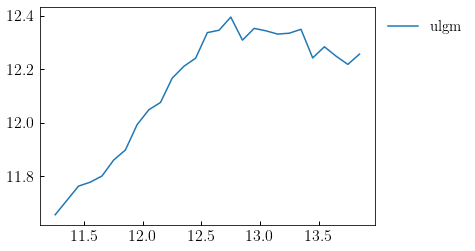

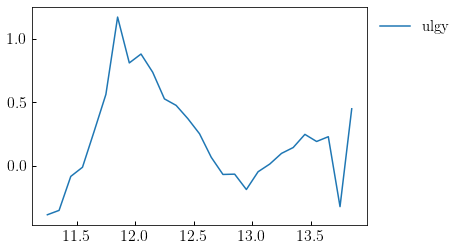

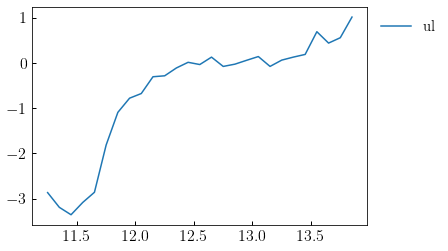

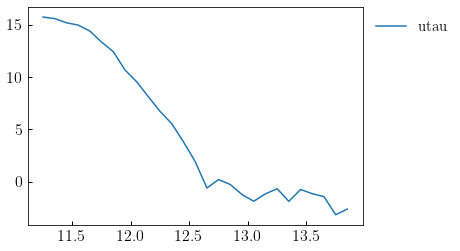

In [13]:
for i in _free_params[:4]:
    plt.plot(massvalsc, medians_Q[:,i], label=names[i])
    plt.legend(loc=2, bbox_to_anchor=(1.,1.))
    plt.show()

In [137]:
mhalo = 10**res_SMDPL[0][4]

mstar_frac = 0.5
_index_high_50 = return_searchsorted_like_results(mhalo, mstar_frac)
t50 = jax_np_interp_vmap(mhalo[:,-1] * mstar_frac, mhalo, SMDPL_t, _index_high_50)


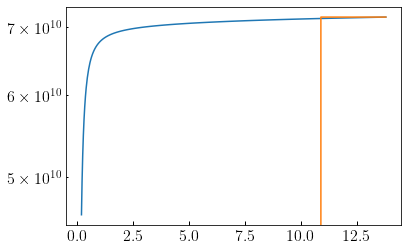

In [155]:
plt.plot(SMDPL_t, mhalo[85881])
plt.plot(SMDPL_t, mhalo_SMDPL[85881])

plt.yscale('log')

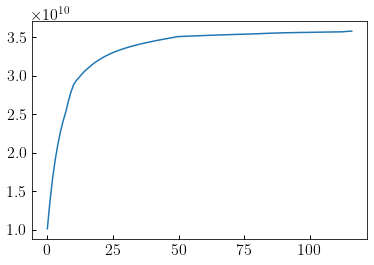

In [148]:
_tmp = mhalo - mhalo[:,[-1]] * mstar_frac

plt.plot(_tmp[85881])

In [95]:
from halotools.utils import sliding_conditional_percentile

jax_np_interp_vmap = jjit(vmap(jax_np_interp, in_axes=(0, 0, None, 0)))

def return_searchsorted_like_results(mstar, mstar_frac):
    _tmp = mstar - mstar[:,[-1]] * mstar_frac
    _tmp[_tmp<0] = np.inf
    _res = np.argmin(_tmp, axis=1)
    _res = np.clip(_res, 1, None).astype(int)
    return _res


mhalo = 10**res_SMDPL[0][4]

mstar_frac = 0.5
_index_high_50 = return_searchsorted_like_results(mhalo, mstar_frac)
t50 = jax_np_interp_vmap(mhalo[:,-1] * mstar_frac, mhalo, SMDPL_t, _index_high_50)

p50 = sliding_conditional_percentile(logmpeak, t50, window_length = 101)


In [370]:
_res = np.clip(1, 0, None), 
_res

(1,)

In [366]:
(_index_high_50==0).sum(), _index_high_50.shape

(222, (93359,))

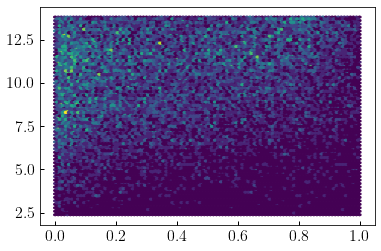

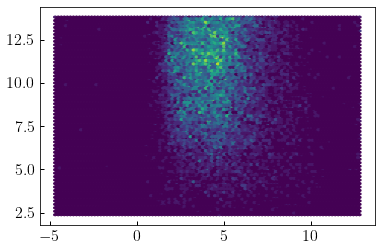

In [119]:
qtime = 10**fit_params[:,5]
sel = qtime < TODAY

plt.hexbin(p50[sel], qtime[sel])
plt.show()
plt.hexbin(t50[sel], qtime[sel])
plt.show()

In [127]:
plt.hist(t50)
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdba4a76170> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fdba4ab74d0> (for post_execute):


KeyboardInterrupt: 

In [131]:
t50.min()

DeviceArray(-5.171527, dtype=float32)

## All fits

In [43]:
def _fun(x, ymin, ymax):
    return _sigmoid(x, 13., 0.5, ymin, ymax)


@jjit
def _bound_cov_diag(x):
    return _sigmoid(x, 0.5, 4.0, 0.0, 10.0)


@jjit
def _bound_cov_offdiag(x):
    return _sigmoid(x, 0.0, 4.0, -1.0, 1.0)


@jjit
def _sigmoid(x, logtc, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1.0 + jnp.exp(-k * (x - logtc)))


def _fun_Mcrit(x, ymin, ymax):
    return _sigmoid(x, 12.0, 4.0, ymin, ymax)

def _fun_QT(x, ymin, ymax):
    return _sigmoid(x, 13.0, 4.0, ymin, ymax)

median_lims = np.zeros((2,9))
cov_lims = np.zeros((2,9,9))

for i in range(9):
    _mask = np.isfinite(medians[:,i])
    _res = curve_fit(_fun, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
    median_lims[:,i] = _res[0]
    
i = 0
_mask = np.isfinite(medians[:,i])
_res = curve_fit(_fun_Mcrit, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
median_lims[:,i] = _res[0]
i = 2
_mask = np.isfinite(medians[:,i]) & (massvalsc > 12.0)
_res = curve_fit(_fun, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
median_lims[:,i] = _res[0] 
i = 3
_mask = np.isfinite(medians[:,i]) & (massvalsc < 12.5)
_res = curve_fit(_fun, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
median_lims[:,i] = _res[0] 
    
i = 5
_mask = np.isfinite(medians[:,i]) & (medians[:,i] < np.log10(TODAY)+0.1)
_res = curve_fit(_fun, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
#_res = curve_fit(_fun_QT, massvalsc[_mask], medians[_mask,i], p0 = [medians[_mask,i][0], medians[_mask,i][-1]])
median_lims[:,i] = _res[0]

def _fun_cov_diag(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    return _bound_cov_diag(_res)

def _fun_cov_diag_lgy(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 12.0, 4.0, ymin, ymax)
    return _bound_cov_diag(_res)

def _fun_cov_offdiag(x, ymin, ymax):
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    return _bound_cov_offdiag(_res)
    
for i in range(9):
    _mask = np.isfinite(sigmas[:,i])
    _res = curve_fit(_fun_cov_diag, massvalsc[_mask], sigmas[_mask,i], 
                     p0 = [sigmas[_mask,i][0], sigmas[_mask,i][-1]])
    cov_lims[:,i,i] = _res[0]   
 
            
for i in range(9):
    for j in range(9):
        if i>j:
            _mask = np.isfinite(corrs[:,i,j])
            _res = curve_fit(_fun_cov_offdiag, massvalsc[_mask], corrs[_mask,i,j], 
                             p0 = [corrs[_mask,i,j][0], corrs[_mask,i,j][-1]])
            cov_lims[:,i,j] = _res[0]   
            #cov_lims[:,i,j] = [0.0, 0.0]


In [41]:
i

3

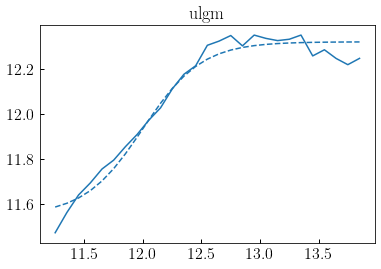

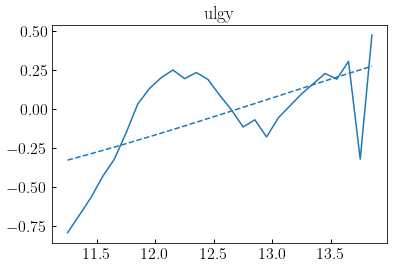

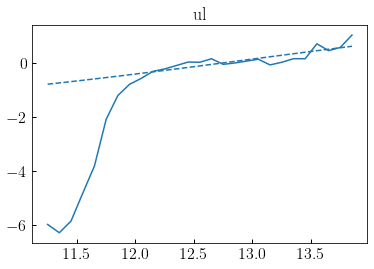

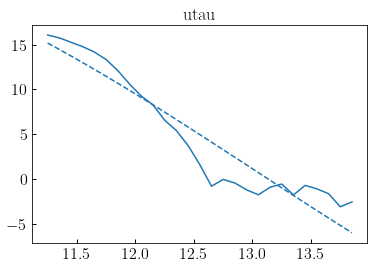

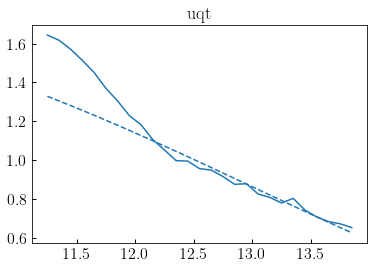

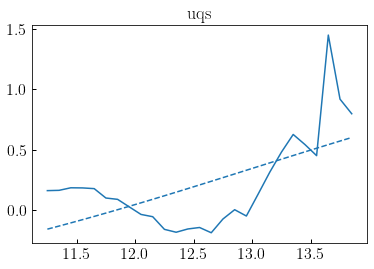

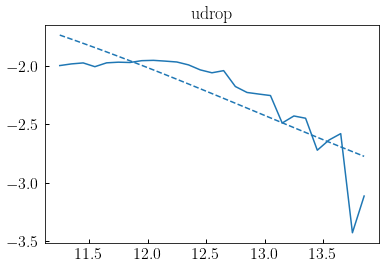

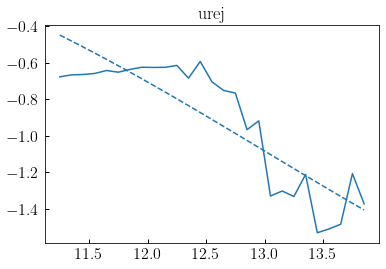

In [101]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:4]:
    line=plt.plot(massvalsc, medians[:,i])[0]
    if i==0:
        plt.plot(massvalsc, _fun_Mcrit(massvalsc, *median_lims[:,i]), ls='--', color = line.get_color())
    else:
        plt.plot(massvalsc, _fun(massvalsc, *median_lims[:,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()
    
    
for i in _free_params[4:]:
    line=plt.plot(massvalsc, medians[:,i])[0]
    if i==10:
        plt.plot(massvalsc, _fun_QT(massvalsc, *median_lims[:,i]), ls='--', color = line.get_color())
    else:
        plt.plot(massvalsc, _fun(massvalsc, *median_lims[:,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()

In [169]:
fit_params.shape

(93359, 9)

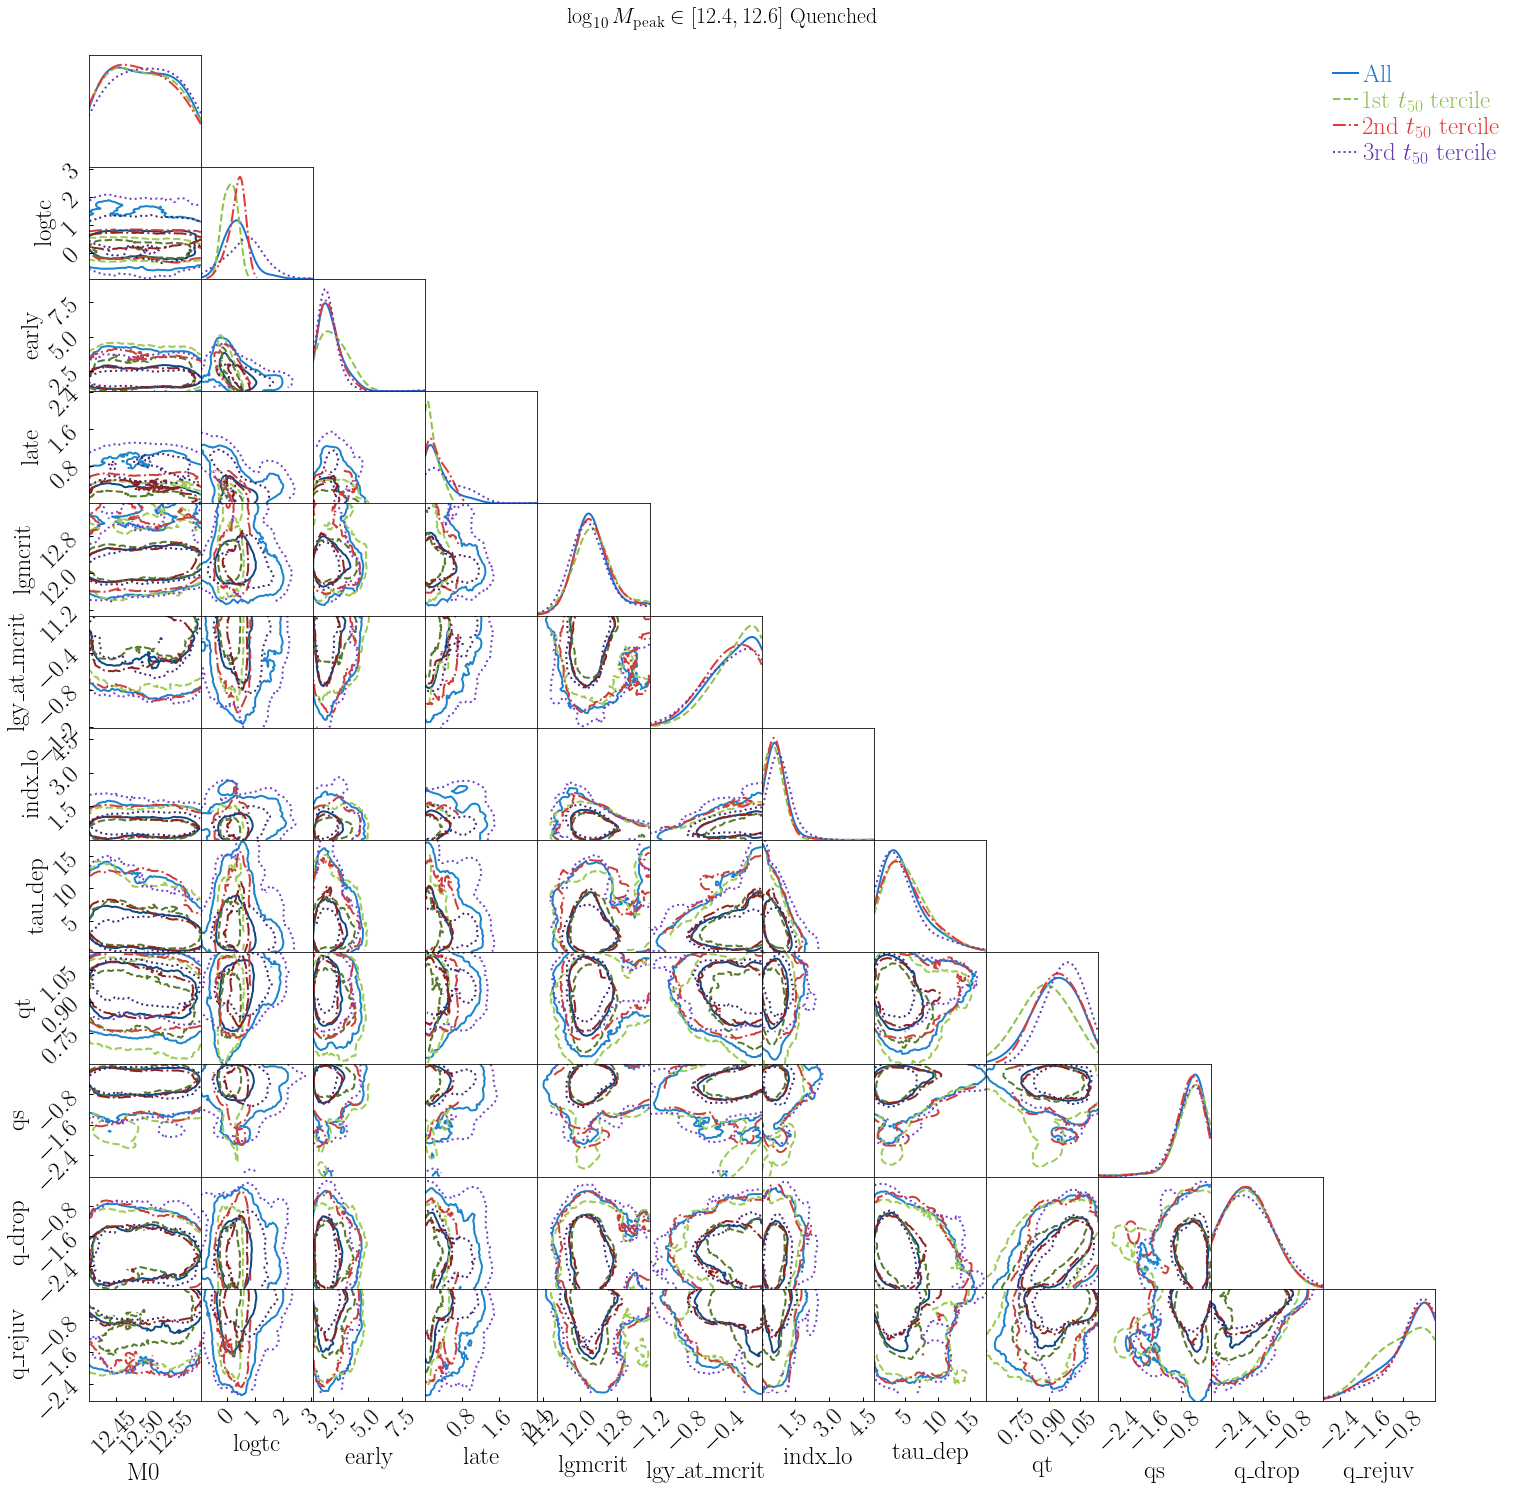

In [199]:
masslow, masshigh = 12.4, 12.6

c = ChainConsumer()

param_labels = ['M0', 'logtc', 'early', 'late']
param_labels += np.array([x.replace('_','\_') for x in sfr_colnames])[[0,1,2,4]].tolist()
param_labels += [x.replace('_','\_') for x in q_colnames]

kde = True
bounded = False

mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))

t50_mask = t50[mask_mass]

fit_params_plot = np.concatenate((
    mah_params_SMDPL[mask_mass][:,[1,2,4,5]],
    fit_params[mask_mass][:,[0,1,2,4,5,6,7,8]]
), axis=1)

t50_bins = np.percentile(t50_mask, np.linspace(0,100,4))

_sel0 = (t50_mask > t50_bins[0]) & (t50_mask <= t50_bins[1])
_sel1 = (t50_mask > t50_bins[1]) & (t50_mask <= t50_bins[2])
_sel2 = (t50_mask > t50_bins[2]) & (t50_mask <= t50_bins[3])
        
    

c.add_chain(fit_params_plot, 
            parameters=param_labels,
            name='All',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel0], 
            parameters=param_labels,
            name=r'1st $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel1], 
            parameters=param_labels,
            name=r'2nd $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel2], 
            parameters=param_labels,
            name=r'3rd $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.configure(
    statistics="max", #shade_alpha=np.ones(len(true_params))*0.8, 
    #linewidths=np.ones(len(true_params))*2,
    linestyles= ['-','--','-.',':'],
    legend_kwargs={"loc": "upper left", "fontsize": 25},
    max_ticks=4
           )
fig = c.plotter.plot(figsize=(22, 22))
axes = fig.axes
size = 25
for ax in axes:
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    ax.xaxis.label.set_size(size)
    ax.yaxis.label.set_size(size)
bounded_label = 'bounded' if bounded else 'unbounded'
kde_label = 'kde' if kde else 'nokde'

fig.suptitle('$\log_{10} M_{\mathrm{peak}} \in [%.1f, %.1f]$ Quenched'%(masslow,masshigh), fontsize=22)

out_plot_path="./"
#fig.savefig(out_plot_path+f'mah_smah_params_countours_{kde_label}.png', bbox_inches='tight', dpi=300)
fig.savefig(out_plot_path+f'mah_smah_params_countours_3t50_Q_populations_%.1f_%.1f.png'%(masslow,masshigh), 
            bbox_inches='tight', dpi=300)
plt.show()

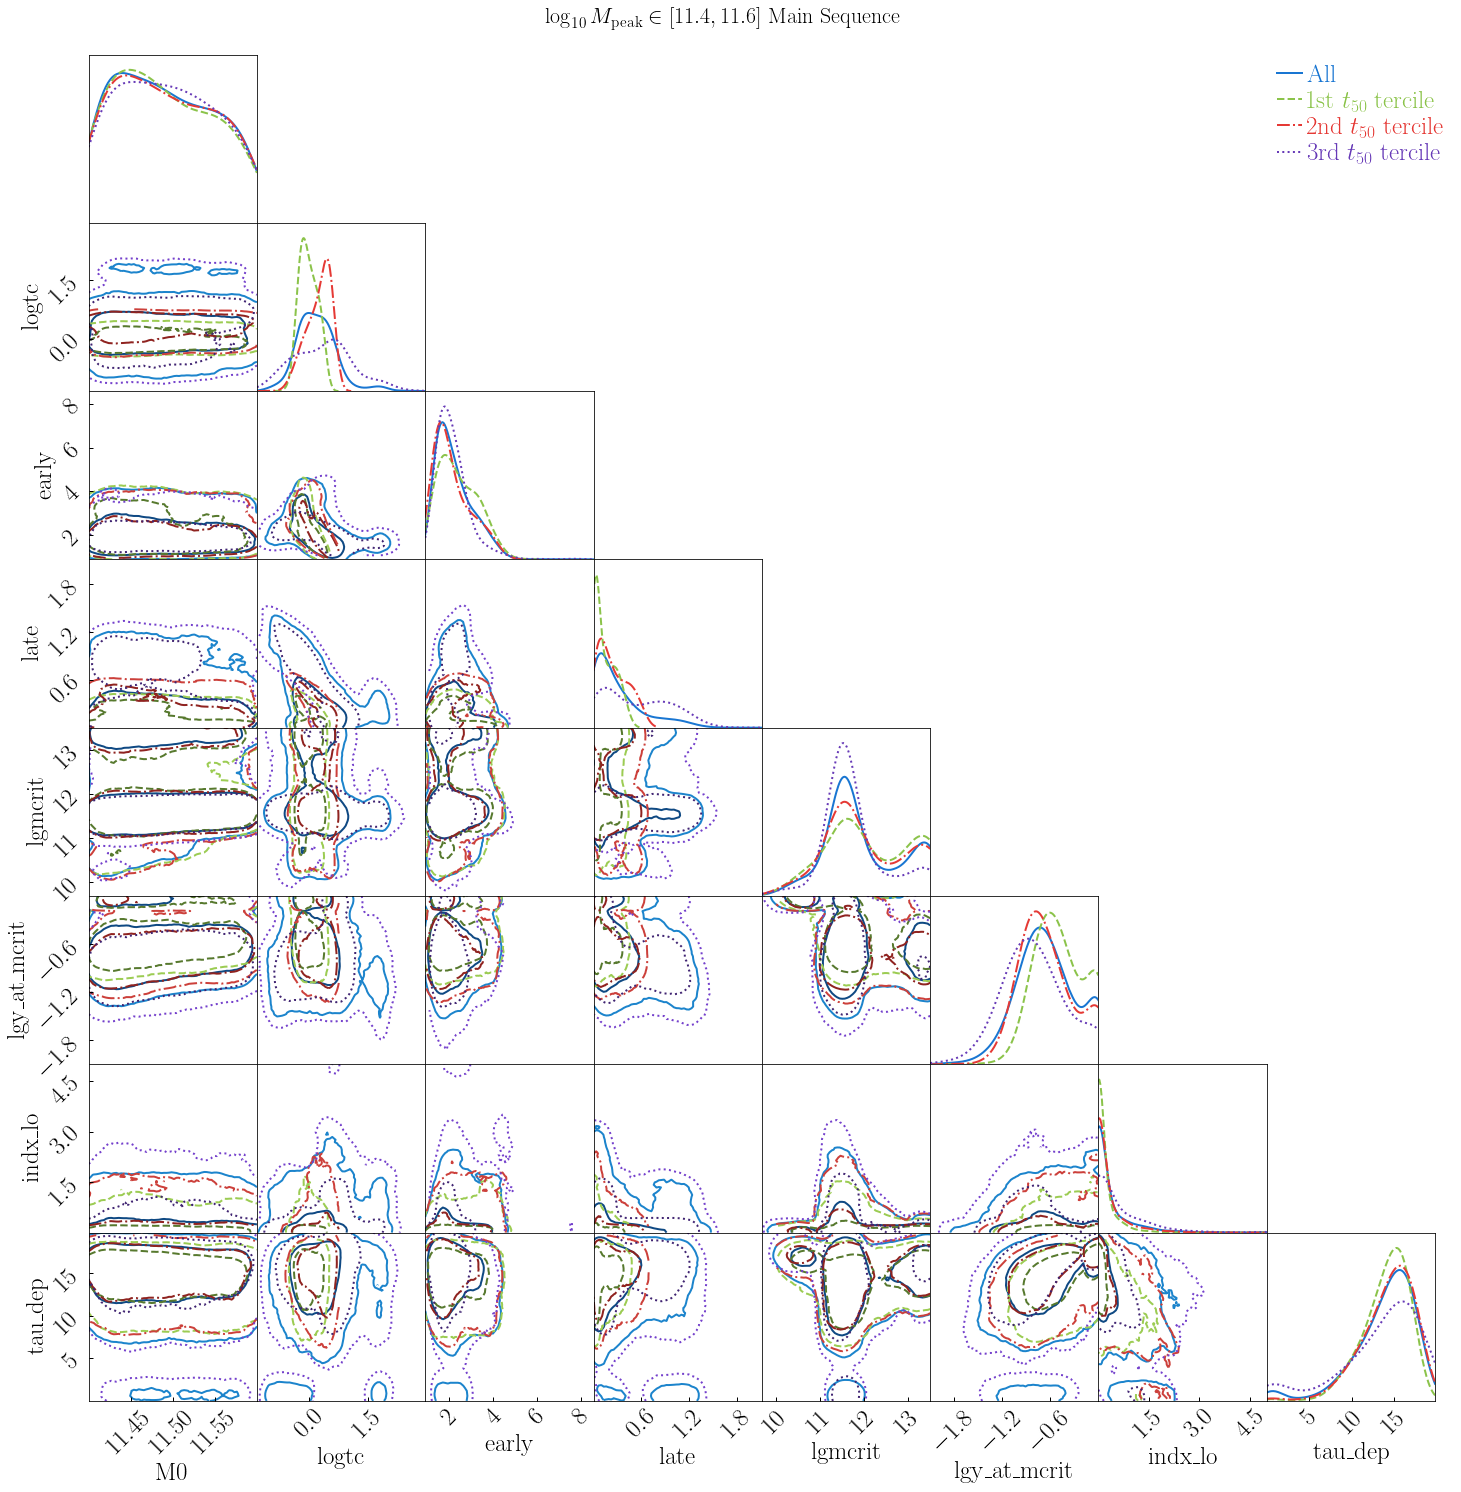

In [200]:
masslow, masshigh = 11.4, 11.6

c = ChainConsumer()

param_labels = ['M0', 'logtc', 'early', 'late']
param_labels += np.array([x.replace('_','\_') for x in sfr_colnames])[[0,1,2,4]].tolist()

kde = True
bounded = False

mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] > np.log10(TODAY))

t50_mask = t50[mask_mass]

fit_params_plot = np.concatenate((
    mah_params_SMDPL[mask_mass][:,[1,2,4,5]],
    fit_params[mask_mass][:,[0,1,2,4]]
), axis=1)

t50_bins = np.percentile(t50_mask, np.linspace(0,100,4))

_sel0 = (t50_mask > t50_bins[0]) & (t50_mask <= t50_bins[1])
_sel1 = (t50_mask > t50_bins[1]) & (t50_mask <= t50_bins[2])
_sel2 = (t50_mask > t50_bins[2]) & (t50_mask <= t50_bins[3])
        
    

c.add_chain(fit_params_plot, 
            parameters=param_labels,
            name='All',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel0], 
            parameters=param_labels,
            name=r'1st $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel1], 
            parameters=param_labels,
            name=r'2nd $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(fit_params_plot[_sel2], 
            parameters=param_labels,
            name=r'3rd $t_{50}$ tercile',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.configure(
    statistics="max", #shade_alpha=np.ones(len(true_params))*0.8, 
    #linewidths=np.ones(len(true_params))*2,
    linestyles= ['-','--','-.',':'],
    legend_kwargs={"loc": "upper left", "fontsize": 25},
    max_ticks=4
           )
fig = c.plotter.plot(figsize=(22, 22))
axes = fig.axes
size = 25
for ax in axes:
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    ax.xaxis.label.set_size(size)
    ax.yaxis.label.set_size(size)
bounded_label = 'bounded' if bounded else 'unbounded'
kde_label = 'kde' if kde else 'nokde'

fig.suptitle('$\log_{10} M_{\mathrm{peak}} \in [%.1f, %.1f]$ Main Sequence'%(masslow,masshigh), fontsize=22)

out_plot_path="./"
#fig.savefig(out_plot_path+f'mah_smah_params_countours_{kde_label}.png', bbox_inches='tight', dpi=300)
fig.savefig(out_plot_path+f'mah_smah_params_countours_3t50_MS_populations_%.1f_%.1f.png'%(masslow,masshigh), 
            bbox_inches='tight', dpi=300)
plt.show()

In [13]:
from diffstarpop.pdf_quenched import get_smah_means_and_covs_quench, DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.star_wrappers import DEFAULT_UNBOUND_SFR_PARAMS_DICT
UH = DEFAULT_UNBOUND_SFR_PARAMS_DICT["indx_hi"]


In [27]:
_res = get_smah_means_and_covs_quench(np.array([12.5]), **DEFAULT_SFH_PDF_QUENCH_PARAMS)

N=int(1e4)
gaussian_sfh_unbound = np.random.multivariate_normal(_res[1][0], _res[2][0], size=N)

gaussian_sfh_bound = np.zeros_like(gaussian_sfh_unbound)

gaussian_sfh_unbound_mainseq = np.zeros((N,5))
gaussian_sfh_unbound_mainseq[:,:3] = gaussian_sfh_unbound[:,:3]
gaussian_sfh_unbound_mainseq[:,3] = UH
gaussian_sfh_unbound_mainseq[:,4] = gaussian_sfh_unbound[:,3]
gaussian_sfh_unbound_mainseq_bound = np.array(_get_bounded_sfr_params_vmap(*gaussian_sfh_unbound_mainseq.T)).T

gaussian_sfh_unbound_quench = gaussian_sfh_unbound[:,4:]
gaussian_sfh_unbound_quench_bound = np.array(_get_bounded_q_params_vmap(*gaussian_sfh_unbound_quench.T)).T

gaussian_sfh_bound[:,:4] = gaussian_sfh_unbound_mainseq_bound[:,[0,1,2,4]]
gaussian_sfh_bound[:,4:] = gaussian_sfh_unbound_quench_bound

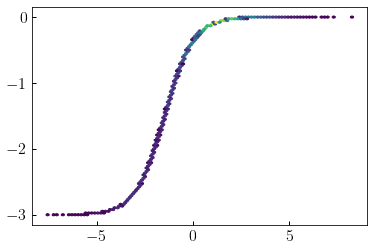

In [29]:
plt.hexbin(gaussian_sfh_unbound_mainseq[:,1], gaussian_sfh_bound[:,1], gridsize=100, mincnt=1)

In [18]:
masslow, masshigh = 12.4, 12.6
mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))


fit_params_plot = u_fit_params[mask_mass][:,[0,1,2,4,5,6,7,8]].copy()


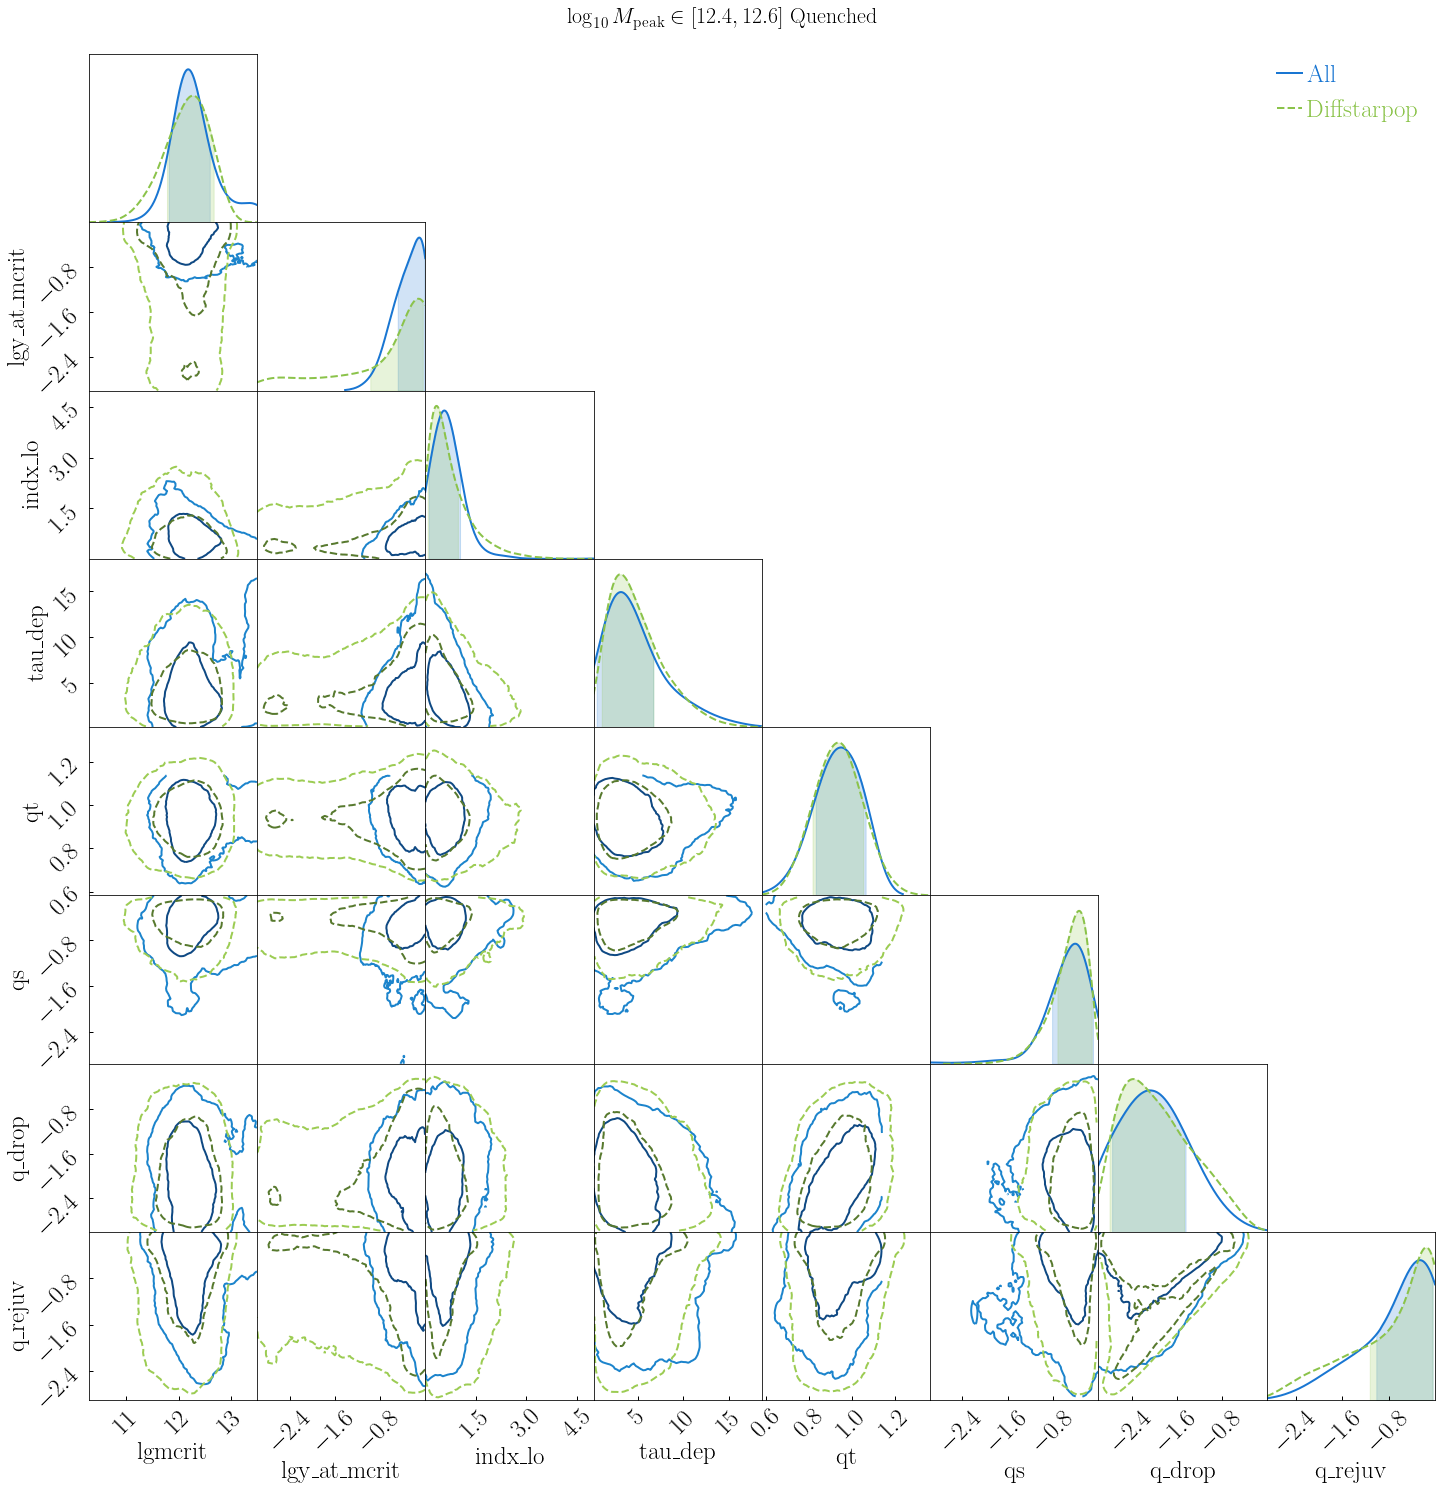

In [19]:
masslow, masshigh = 12.4, 12.6

c = ChainConsumer()

#param_labels = ['M0', 'logtc', 'early', 'late']
param_labels = np.array([x.replace('_','\_') for x in sfr_colnames])[[0,1,2,4]].tolist()
param_labels += [x.replace('_','\_') for x in q_colnames]

kde = True
bounded = False

mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))


fit_params_plot = fit_params[mask_mass][:,[0,1,2,4,5,6,7,8]].copy()
"""
t50_mask = t50[mask_mass]
t50_bins = np.percentile(t50_mask, np.linspace(0,100,4))

_sel0 = (t50_mask > t50_bins[0]) & (t50_mask <= t50_bins[1])
_sel1 = (t50_mask > t50_bins[1]) & (t50_mask <= t50_bins[2])
_sel2 = (t50_mask > t50_bins[2]) & (t50_mask <= t50_bins[3])
"""     
    

c.add_chain(fit_params_plot, 
            parameters=param_labels,
            name='All',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )

c.add_chain(gaussian_sfh_bound, 
            parameters=param_labels,
            name='Diffstarpop',
            #color=colors_def[0],
            kde=kde, shade_alpha=0.5, linewidth=2, shade=False
           )




c.configure(
    statistics="max", #shade_alpha=np.ones(len(true_params))*0.8, 
    #linewidths=np.ones(len(true_params))*2,
    linestyles= ['-','--'],
    legend_kwargs={"loc": "upper left", "fontsize": 25},
    max_ticks=4
           )
fig = c.plotter.plot(figsize=(22, 22))
axes = fig.axes
size = 25
for ax in axes:
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(size) 
    ax.xaxis.label.set_size(size)
    ax.yaxis.label.set_size(size)
bounded_label = 'bounded' if bounded else 'unbounded'
kde_label = 'kde' if kde else 'nokde'

fig.suptitle('$\log_{10} M_{\mathrm{peak}} \in [%.1f, %.1f]$ Quenched'%(masslow,masshigh), fontsize=22)

out_plot_path="./"
#fig.savefig(out_plot_path+f'mah_smah_params_countours_{kde_label}.png', bbox_inches='tight', dpi=300)

plt.show()

In [27]:
from scipy.optimize import minimize

      fun: 1.8519983378976668
 hess_inv: array([[ 0.13459596, -0.3434178 ],
       [-0.3434178 ,  0.87622087]])
      jac: array([-188192.93338685,  601225.07619359])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 76
      nit: 1
     njev: 22
   status: 2
  success: False
        x: array([12.25208169, -0.60000059])
[12.25208169  0.2511883 ]


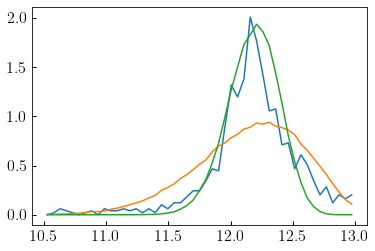

In [81]:
masslow, masshigh = 12.4, 12.6
mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))


fit_params_plot = fit_params[mask_mass][:,[0,1,2,4,5,6,7,8]].copy()


bins_lims=[
    [10.5,13.0],
    [-3.0,0.0],
    [0.0,5.0],
    [0.0,20.0],
    [0.0,1.5],
    [-3.0,0.0],
    [-3.0,0.0],
    [-3.0,0.0],
]

means_guess = np.concatenate((
    np.mean(gaussian_sfh_unbound_mainseq, axis=0)[[0,1,2,4]],
    np.mean(gaussian_sfh_unbound_quench, axis=0)
))
std_guess = np.concatenate((
    np.std(gaussian_sfh_unbound_mainseq, axis=0)[[0,1,2,4]],
    np.std(gaussian_sfh_unbound_quench, axis=0)
))


for i in range(4):
    bins = np.linspace(bins_lims[i][0], bins_lims[i][1], 50)
    binsc = 0.5*(bins[1:]+bins[:-1])
    target_data = np.histogram(fit_params_plot, bins, density=1)[0]
    
    def funval(param_bins, bin_id, mean, std):
        _vals_unbound = np.random.normal(mean, std, int(1e5)*5).reshape((int(1e5),5))
        _vals_bound = np.array(_get_bounded_sfr_params_vmap(*_vals_unbound.T)).T[:,bin_id]
        guess_data = np.histogram(_vals_bound, param_bins, density=1)[0]
        return guess_data
    
    def fun(params, param_bins, target_data, bin_id):
        mean, logstd = params
        std = 10**logstd
        guess_data = funval(param_bins, bin_id, mean, std)
        loss = np.sum((guess_data - target_data)**2)
        return loss
    
    if i <3:
        bin_id = i
    if i==3:
        bin_id = 4
    _res = minimize(fun, x0 = [means_guess[i], -0.6], args=(bins, target_data, bin_id), method="BFGS")
    print(_res)
    best_fit = _res.x
    best_fit[1] = 10**best_fit[1]
    print(best_fit)
    
    
    #_res = curve_fit(fun, bins, target_data, p0 = [means_guess[i], np.log10(std_guess[i])])
    plt.plot(binsc, target_data)
    plt.plot(binsc, funval(bins, bin_id, means_guess[i], std_guess[i]))
    plt.plot(binsc, funval(bins, bin_id, *best_fit))
    #plt.plot(binsc, funval(bins, 12.25, -0.6))
    
    plt.show()
    break

In [74]:
masslow, masshigh = 12.4, 12.6
mask_mass =  (logmpeak>masslow)&((logmpeak<masshigh)) 
mask_mass &= (fit_params[:,5] < np.log10(TODAY))


fit_params_plot = fit_params[mask_mass][:,[0,1,2,4,5,6,7,8]].copy()


-0.2737171037751007

In [65]:
print(fun([means_guess[i], std_guess[i]], bins, target_data, bin_id))
print(fun(best_fit, bins, target_data, bin_id))

12.372919274715633
11.220358036959135


In [72]:
std_guess[i]

0.5324549835799829

## Quenched fits

In [44]:
def _fun(x, ymin, ymax):
    return _sigmoid(x, 13., 0.5, ymin, ymax)

def _fun_Mcrit(x, ymin, ymax):
    return _sigmoid(x, 12.0, 4.0, ymin, ymax)

def _fun_QT(x, ymin, ymax):
    return _sigmoid(x, 13.0, 4.0, ymin, ymax)



@jjit
def _bound_cov_diag(x):
    return _sigmoid(x, 0.5, 4.0, 0.0, 10.0)


@jjit
def _bound_cov_offdiag(x):
    return _sigmoid(x, 0.0, 4.0, -1.0, 1.0)


@jjit
def _sigmoid(x, logtc, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1.0 + jnp.exp(-k * (x - logtc)))


@jjit
def _fun_cov_diag(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    # return _bound_cov_diag(_res)
    # return jnp.log10(_res)
    return _res

def _fun_cov_diag_lgy(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 12.0, 4.0, ymin, ymax)
    return _bound_cov_diag(_res)

def _fun_cov_offdiag(x, ymin, ymax):
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    return _bound_cov_offdiag(_res)


median_lims_Q = np.zeros((2,9))
cov_lims_Q = np.zeros((2,9,9))

for i in range(9):
    _mask = np.isfinite(medians_Q[:,i])
    _res = curve_fit(_fun, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]], sigma=1.0/fquench[_mask])
    median_lims_Q[:,i] = _res[0]
    
i = 0
_mask = np.isfinite(medians_Q[:,i])
_res = curve_fit(_fun_Mcrit, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]], sigma=1.0/fquench[_mask])
median_lims_Q[:,i] = _res[0]
i = 2
_mask = np.isfinite(medians_Q[:,i]) & (massvalsc > 12.0)
_res = curve_fit(_fun, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]], sigma=1.0/fquench[_mask])
median_lims_Q[:,i] = _res[0] 
i = 3
_mask = np.isfinite(medians_Q[:,i]) & (massvalsc < 12.5)
_res = curve_fit(_fun, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]], sigma=1.0/fquench[_mask])
median_lims_Q[:,i] = _res[0] 
    
i = 5
_mask = np.isfinite(medians_Q[:,i]) & (medians_Q[:,i] < np.log10(TODAY)+0.1)
_res = curve_fit(_fun, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]], sigma=1.0/fquench[_mask])
#_res = curve_fit(_fun_QT, massvalsc[_mask], medians_Q[_mask,i], p0 = [medians_Q[_mask,i][0], medians_Q[_mask,i][-1]])
median_lims_Q[:,i] = _res[0]


    
for i in _free_params:
    _mask = np.isfinite(sigmas_Q[:,i])
    _res = curve_fit(_fun_cov_diag, massvalsc[_mask], np.log10(sigmas_Q[_mask,i]), 
                     p0 = [np.log10(sigmas_Q[_mask,i])[0], np.log10(sigmas_Q[_mask,i])[-1]], sigma=1.0/fquench[_mask])
    cov_lims_Q[:,i,i] = _res[0]   
 
            
for i in range(9):
    for j in range(9):
        if i>j:
            _mask = np.isfinite(corrs_Q[:,i,j])
            _res = curve_fit(_fun_cov_offdiag, massvalsc[_mask], corrs_Q[_mask,i,j], 
                             p0 = [corrs_Q[_mask,i,j][0], corrs_Q[_mask,i,j][-1]], sigma=1.0/fquench[_mask])
            cov_lims_Q[:,i,j] = _res[0]   
            #cov_lims_Q[:,i,j] = [0.0, 0.0]


(0.0, 1.0)

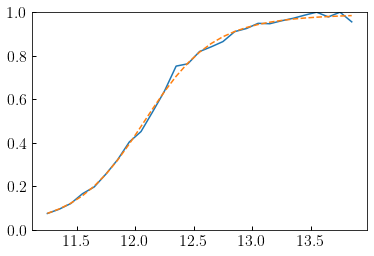

In [46]:
def _bound_fquench(x):
    return _sigmoid(x, 0.5, 4.0, 0.0, 1.0)

def _fun_fquench(x, x0, k, ymin, ymax):
    _res = _sigmoid(x, x0, k, ymin, ymax)
    return _bound_fquench(_res)

median_lims_fquenc = np.zeros(4)
for i in range(9):
    _res = curve_fit(_fun_fquench, massvalsc, fquench, p0 = [13, 4.0, fquench[0], fquench[-1]])
    median_lims_fquenc[:] = _res[0]
    
plt.plot(massvalsc, fquench)
plt.plot(massvalsc, _fun_fquench(massvalsc, *median_lims_fquenc), ls='--')
plt.ylim(0,1)

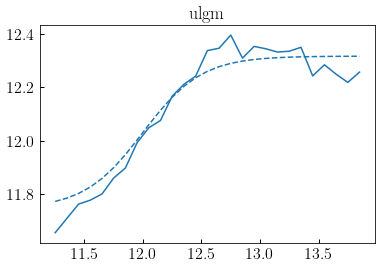

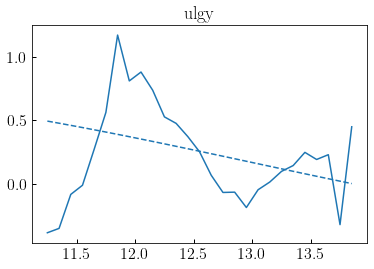

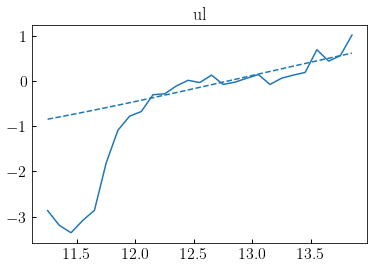

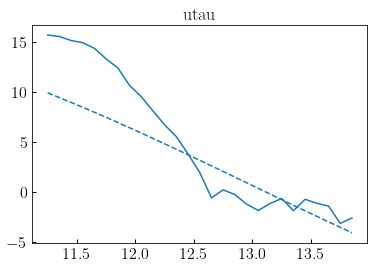

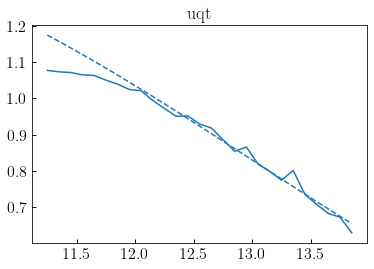

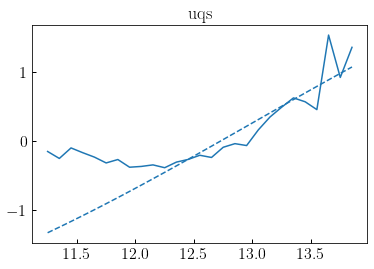

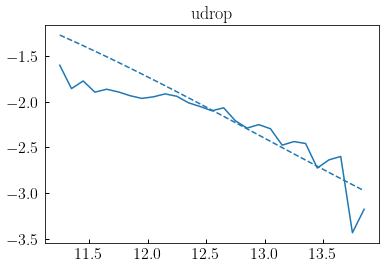

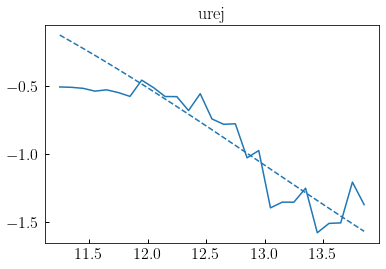

In [300]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:4]:
    line=plt.plot(massvalsc, medians_Q[:,i])[0]
    if i==0:
        plt.plot(massvalsc, _fun_Mcrit(massvalsc, *median_lims_Q[:,i]), ls='--', color = line.get_color())
    else:
        plt.plot(massvalsc, _fun(massvalsc, *median_lims_Q[:,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()
    
    
for i in _free_params[4:]:
    line=plt.plot(massvalsc, medians_Q[:,i])[0]
    if i==1000:
        plt.plot(massvalsc, _fun_QT(massvalsc, *median_lims_Q[:,i]), ls='--', color = line.get_color())
    else:
        plt.plot(massvalsc, _fun(massvalsc, *median_lims_Q[:,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()

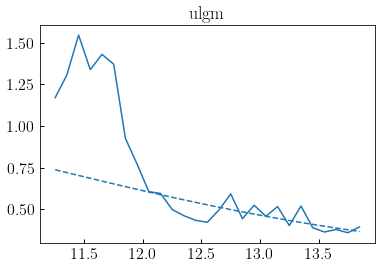

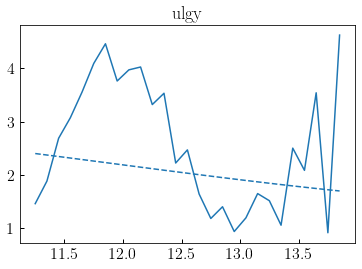

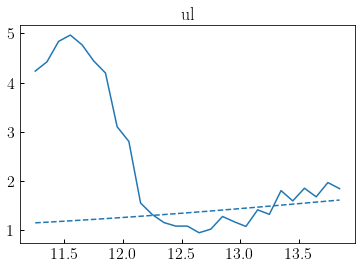

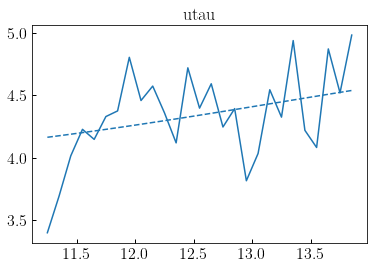

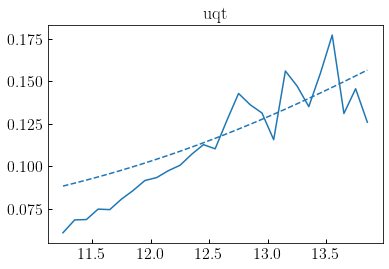

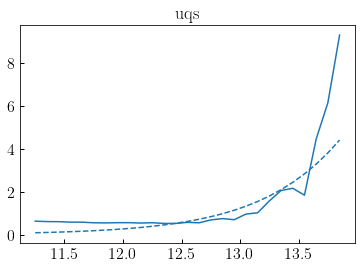

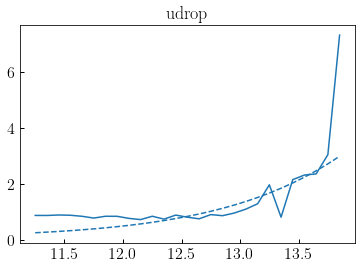

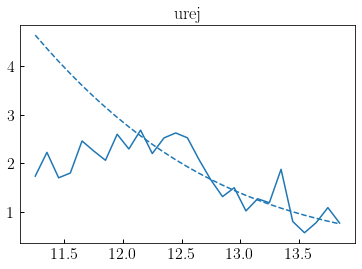

In [46]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:]:
    line=plt.plot(massvalsc, sigmas_Q[:,i])[0]

    plt.plot(massvalsc, 10**_fun_cov_diag(massvalsc, *cov_lims_Q[:,i,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()

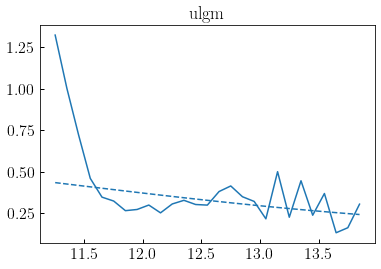

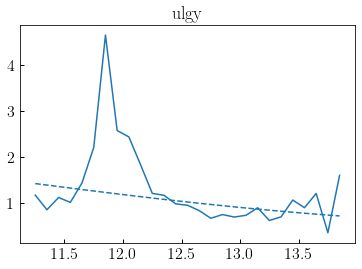

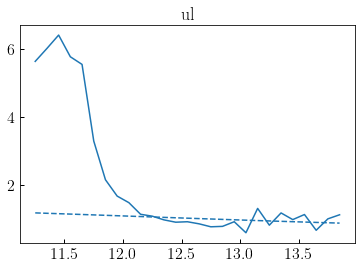

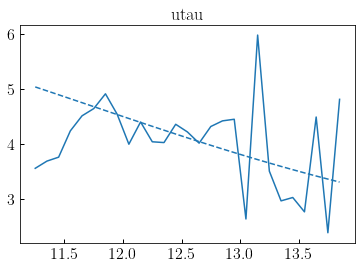

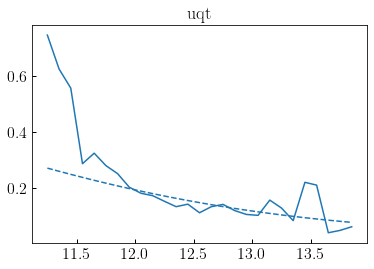

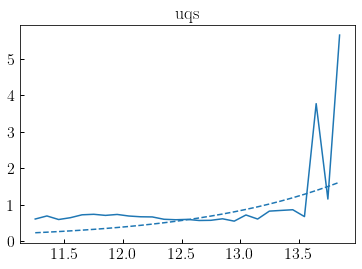

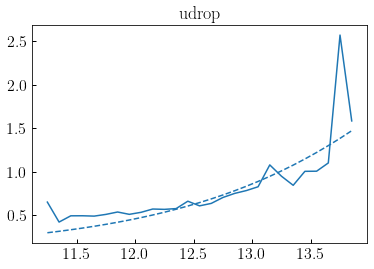

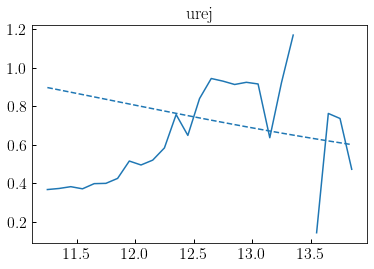

In [144]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:]:
    line=plt.plot(massvalsc, sigmas_Q[:,i])[0]

    plt.plot(massvalsc, 10**_fun_cov_diag(massvalsc, *cov_lims_Q[:,i,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()

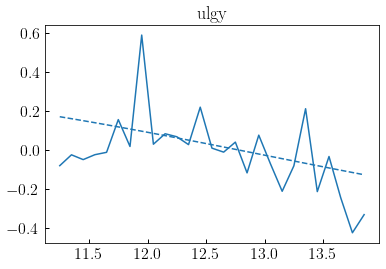

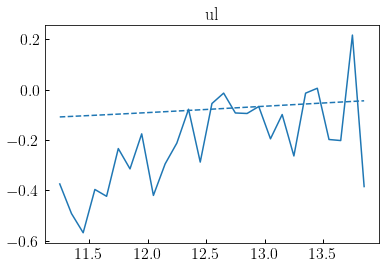

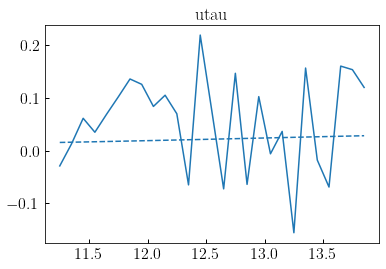

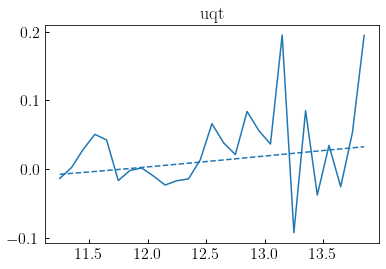

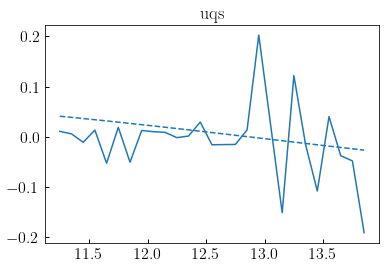

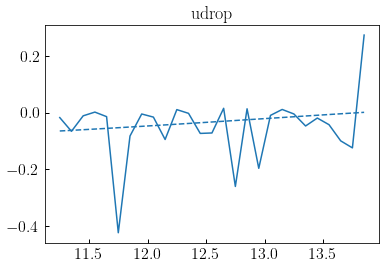

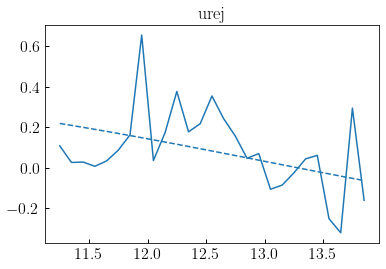

In [34]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[1:]:
    line=plt.plot(massvalsc, corrs_Q[:,i,0])[0]

    plt.plot(massvalsc, _fun_cov_diag(massvalsc, *cov_lims_Q[:,i,0]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()

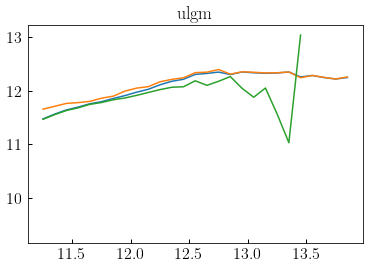

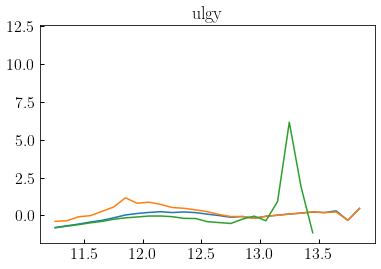

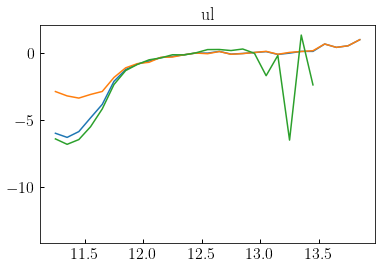

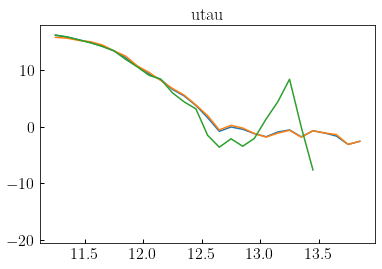

In [70]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:4]:
    line=plt.plot(massvalsc, medians[:,i])[0]
    line=plt.plot(massvalsc, medians_Q[:,i])[0]
    line=plt.plot(massvalsc, medians_MS[:,i])[0]

    plt.title(names[i])
    plt.show()

## Main Sequence fits

In [45]:
def _fun(x, ymin, ymax):
    return _sigmoid(x, 13., 0.5, ymin, ymax)

def _fun_Mcrit(x, ymin, ymax):
    return _sigmoid(x, 12.0, 4.0, ymin, ymax)

def _fun_MST(x, ymin, ymax):
    return _sigmoid(x, 13.0, 4.0, ymin, ymax)



@jjit
def _bound_cov_diag(x):
    return _sigmoid(x, 0.5, 4.0, 0.0, 10.0)


@jjit
def _bound_cov_offdiag(x):
    return _sigmoid(x, 0.0, 4.0, -1.0, 1.0)


@jjit
def _sigmoid(x, logtc, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1.0 + jnp.exp(-k * (x - logtc)))


@jjit
def _fun_cov_diag(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    # return _bound_cov_diag(_res)
    # return jnp.log10(_res)
    return _res

def _fun_cov_diag_lgy(x, ymin, ymax):
    #_res = _sigmoid(x, 13, 0.5, ymin, ymax)
    _res = _sigmoid(x, 12.0, 4.0, ymin, ymax)
    return _bound_cov_diag(_res)

def _fun_cov_offdiag(x, ymin, ymax):
    _res = _sigmoid(x, 13.0, 0.5, ymin, ymax)
    return _bound_cov_offdiag(_res)


median_lims_MS = np.zeros((2,9))
cov_lims_MS = np.zeros((2,9,9))

for i in range(9):
    _mask = np.isfinite(medians_MS[:,i])
    _res = curve_fit(_fun, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
    median_lims_MS[:,i] = _res[0]
    
i = 0
_mask = np.isfinite(medians_MS[:,i]) & (massvalsc < 12.8)
#_res = curve_fit(_fun_Mcrit, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
_res = curve_fit(_fun, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
median_lims_MS[:,i] = _res[0]
i = 1
_mask = np.isfinite(medians_MS[:,i]) & (massvalsc < 12.8)
_res = curve_fit(_fun, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
median_lims_MS[:,i] = _res[0] 
i = 2
_mask = np.isfinite(medians_MS[:,i]) & (massvalsc < 12.8)
_res = curve_fit(_fun, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
median_lims_MS[:,i] = _res[0] 
i = 4
_mask = np.isfinite(medians_MS[:,i]) & (massvalsc < 12.5)
_res = curve_fit(_fun, massvalsc[_mask], medians_MS[_mask,i], p0 = [medians_MS[_mask,i][0], medians_MS[_mask,i][-1]], sigma=fquench[_mask])
median_lims_MS[:,i] = _res[0] 
    
    
for i in _free_params:
    _mask = np.isfinite(sigmas_MS[:,i]) & (sigmas_MS[:,i]>0.0)
    _res = curve_fit(_fun_cov_diag, massvalsc[_mask], np.log10(sigmas_MS[_mask,i]), 
                     p0 = [np.log10(sigmas_MS[_mask,i])[0], np.log10(sigmas_MS[_mask,i])[-1]], sigma=fquench[_mask])
    cov_lims_MS[:,i,i] = _res[0]   
 
            
for i in range(9):
    for j in range(9):
        if i>j:
            _mask = np.isfinite(corrs_MS[:,i,j])
            _res = curve_fit(_fun_cov_offdiag, massvalsc[_mask], corrs_MS[_mask,i,j], 
                             p0 = [corrs_MS[_mask,i,j][0], corrs_MS[_mask,i,j][-1]], sigma=fquench[_mask])
            cov_lims_MS[:,i,j] = _res[0]   
            #cov_lims_MS[:,i,j] = [0.0, 0.0]


In [45]:
_free_params[:4]

array([0, 1, 2, 4])

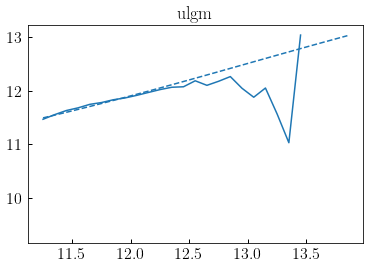

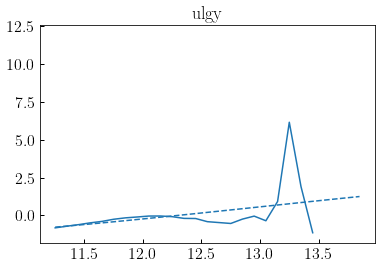

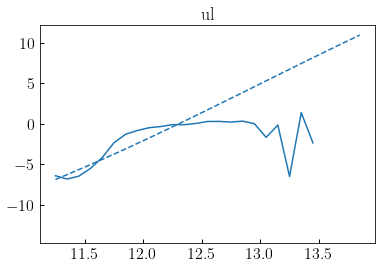

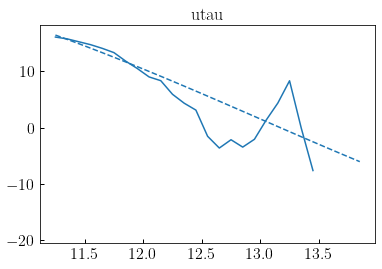

In [326]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

for i in _free_params[:4]:
    line=plt.plot(massvalsc, medians_MS[:,i])[0]
    if i==10:
        plt.plot(massvalsc, _fun_Mcrit(massvalsc, *median_lims_MS[:,i]), ls='--', color = line.get_color())
    else:
        plt.plot(massvalsc, _fun(massvalsc, *median_lims_MS[:,i]), ls='--', color = line.get_color())
    plt.title(names[i])
    plt.show()
    


array([11.5, 12. , 12.5, 13. , 13.5])

# p50 correlations

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


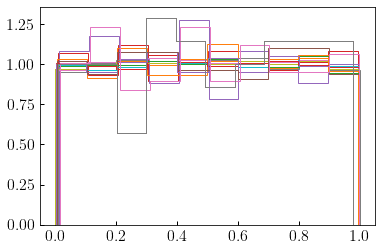

In [331]:
p50_bins = np.linspace(0,1,10)
p50_binsc = 0.5*(p50_bins[1:] + p50_bins[:-1])


#massvals_p50 = np.arange(11.2, 13.99, 0.5)
#massvalsc_p50 = 0.5*(massvals_p50[1:]+massvals_p50[:-1])

massvalsc_p50 = np.linspace(11.5, 13.75, 6)
massvalsc_p50_MS = np.linspace(11.5, 13.0, 6)
massvalsc_p50_Q = np.linspace(12.0, 13.75, 6)
massvalsc_p50_binwidth = 0.1

medians_p50 = np.zeros((len(massvalsc_p50),len(p50_binsc),9))
medians_p50_Q = np.zeros((len(massvalsc_p50_Q),len(p50_binsc),9))
medians_p50_MS = np.zeros((len(massvalsc_p50_MS),len(p50_binsc),9))


for i in range(len(massvalsc_p50)):
    mask_mass = (logmpeak>massvalsc_p50[i]-massvalsc_p50_binwidth)&((logmpeak<massvalsc_p50[i]+massvalsc_p50_binwidth))
    
    quenched = (10**res_SMDPL[1][:, 5] <= TODAY)
    
    p50_masked = p50[mask_mass]
    plt.hist(p50_masked, histtype='step', density=1)

    for j in range(len(p50_binsc)):
        _sel = mask_mass & (p50 > p50_bins[j]) & (p50 < p50_bins[j+1])        
        medians_p50[i,j] = np.median(fit_params[_sel],axis=0)
        

for i in range(len(massvalsc_p50_MS)):
    mask_mass = (logmpeak>massvalsc_p50_MS[i]-massvalsc_p50_binwidth)&((logmpeak<massvalsc_p50_MS[i]+massvalsc_p50_binwidth))
    
    quenched = (10**res_SMDPL[1][:, 5] <= TODAY)
    
    p50_masked = p50[mask_mass]
    plt.hist(p50_masked, histtype='step', density=1)

    
    for j in range(len(p50_binsc)):
        _sel = mask_mass & (p50 > p50_bins[j]) & (p50 < p50_bins[j+1]) & (~quenched)
        medians_p50_MS[i,j] = np.median(u_fit_params[_sel],axis=0)

for i in range(len(massvalsc_p50_Q)):
    mask_mass = (logmpeak>massvalsc_p50_Q[i]-massvalsc_p50_binwidth)&((logmpeak<massvalsc_p50_Q[i]+massvalsc_p50_binwidth))
    
    quenched = (10**res_SMDPL[1][:, 5] <= TODAY)
    
    p50_masked = p50[mask_mass]
    plt.hist(p50_masked, histtype='step', density=1)

    
    for j in range(len(p50_binsc)):
        _sel = mask_mass & (p50 > p50_bins[j]) & (p50 < p50_bins[j+1]) & (quenched)
        medians_p50_Q[i,j] = np.median(u_fit_params[_sel],axis=0)

In [231]:
colnames

['halo_id',
 'lgmcrit',
 'lgy_at_mcrit',
 'indx_lo',
 'indx_hi',
 'tau_dep',
 'qt',
 'qs',
 'q_drop',
 'q_rejuv',
 'loss',
 'success']

In [245]:
_fun_QT(massvalsc_p50, *median_lims_Q[:,_paramid])

DeviceArray([1.6634493 , 1.6421064 , 1.4998457 , 0.9132082 , 0.23019564],            dtype=float32)

[0.05555556 0.16666667 0.27777778 0.38888889 0.5        0.61111111
 0.72222222 0.83333333 0.94444444]


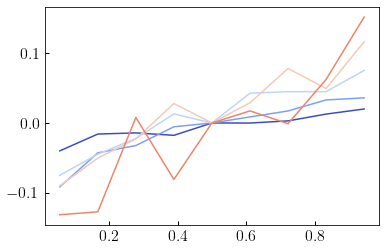

In [293]:

_paramid = 5
print(p50_binsc)
cmap = plt.get_cmap('coolwarm')
for _i in range(len(massvals_p50)-1):
    #plt.plot(p50_binsc, medians_p50[_i, :, _paramid], color = cmap(float(_i)/(len(massvals_p50)-1)))
    #plt.plot(p50_binsc, medians_p50_Q[_i, :, _paramid], color = cmap(float(_i)/(len(massvals_p50)-1)))
    plt.plot(p50_binsc, medians_p50_Q[_i, :, _paramid]- medians_p50_Q[_i, int(len(p50_bins)/2)-1, _paramid], color = cmap(float(_i)/(len(massvals_p50)-1)))
    #plt.plot(p50_binsc, medians_p50[_i, :, _paramid] - medians_p50[_i, int(len(p50_bins)/2)-1, _paramid], 
    #         color = cmap(float(_i)/(len(massvals_p50)-1)))
    
plt.show()

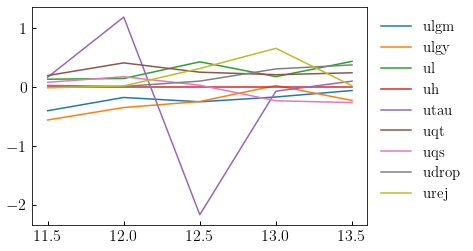

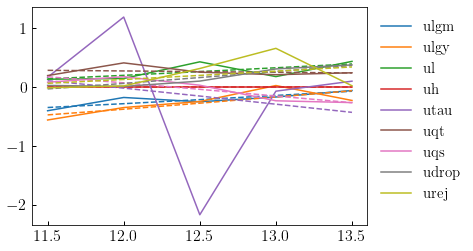

In [294]:

def _fun_R(p50, R):
    return R * (p50 - 0.5)

Rvals = np.zeros((len(massvals_p50)-1,9))
for _i in range(len(massvals_p50)-1):
    for _paramid in range(9):
        _res = curve_fit(_fun_R, 
                         p50_binsc, 
                         medians_p50[_i, :, _paramid] - medians_p50[_i, int(len(p50_bins)/2)-1, _paramid],
                         p0 = [0.]
                        )
        Rvals[_i, _paramid] = _res[0]

for _paramid in range(9):
    plt.plot(massvalsc_p50, Rvals[:,_paramid], label=names[_paramid])
    
plt.legend(bbox_to_anchor=(1.,1.))
    
plt.show()

Rval_lims = np.zeros((2,9))

for i in range(9):
    _res = curve_fit(_fun, massvalsc_p50, Rvals[:,i], p0 = [Rvals[0,i], Rvals[-1,i]])
    Rval_lims[:,i] = _res[0]
    
for i in range(9):
    line, = plt.plot(massvalsc_p50, Rvals[:,i], label=names[i], )
    plt.plot(massvalsc_p50, _fun(massvalsc_p50, *Rval_lims[:,i]), ls='--', color = line.get_color())
    
plt.legend(bbox_to_anchor=(1.,1.))
    
plt.show()

In [332]:
Rvals_Q = np.zeros((len(massvalsc_p50_Q),9))
for _i in range(len(massvalsc_p50_Q)):
    for _paramid in range(9):
        _res = curve_fit(_fun_R, 
                         p50_binsc, 
                         medians_p50_Q[_i, :, _paramid] - medians_p50_Q[_i, int(len(p50_bins)/2)-1, _paramid],
                         p0 = [0.]
                        )
        Rvals_Q[_i, _paramid] = _res[0]


Rval_lims_Q = np.zeros((2,9))

for i in range(9):
    _res = curve_fit(_fun, massvalsc_p50_Q, Rvals_Q[:,i], p0 = [Rvals_Q[0,i], Rvals_Q[-1,i]])
    Rval_lims_Q[:,i] = _res[0]
    

In [317]:
medians_p50_MS[-3, :, 2]

array([-0.421871 , -0.830553 , -0.0176275, -0.479505 , -0.0280633,
        0.2097885, -0.122304 ,  0.0553038,  0.45934  ])

In [333]:
Rvals_MS = np.zeros((len(massvalsc_p50_MS),9))
for _i in range(len(massvalsc_p50_MS)):
    for _paramid in range(5):
        _data = medians_p50_MS[_i, :, _paramid] - medians_p50_MS[_i, int(len(p50_bins)/2)-1, _paramid]
        if np.isnan(_data).all(): continue
        _res = curve_fit(_fun_R, 
                         p50_binsc[np.isfinite(_data)], 
                         _data[np.isfinite(_data)],
                         p0 = [0.]
                        )
        Rvals_MS[_i, _paramid] = _res[0]


Rval_lims_MS = np.zeros((2,9))

for i in range(5):
    _res = curve_fit(_fun, massvalsc_p50_MS, Rvals_MS[:,i], p0 = [Rvals_MS[0,i], Rvals_MS[-1,i]])
    Rval_lims_MS[:,i] = _res[0]
    

In [296]:
#_fun_R(p50_binsc, _fun(massvalsc_p50[_i], *Rval_lims_Q[:,_i]))

_i = 0
_fun(massvalsc_p50[_i], *Rval_lims_Q[:,_i])



DeviceArray(-0.51094115, dtype=float32)

In [285]:
param_labels

['lgmcrit',
 'lgy\\_at\\_mcrit',
 'indx\\_lo',
 'indx\\_hi',
 'tau\\_dep',
 'qt',
 'qs',
 'q\\_drop',
 'q\\_rejuv']

In [372]:
Rval_lims_Q[:,5]

array([-0.03017442,  0.41475974])

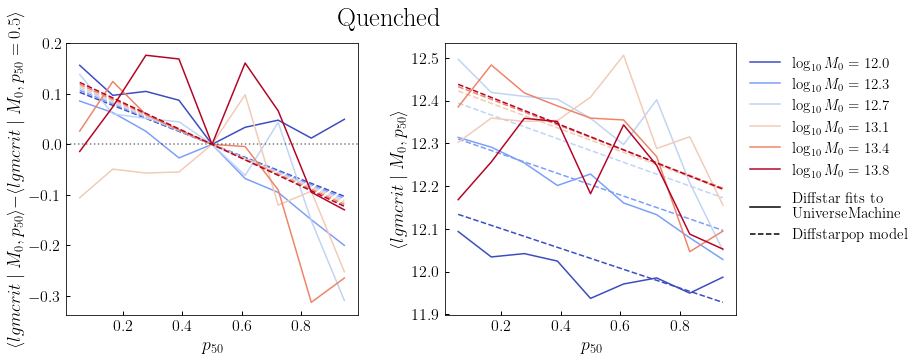

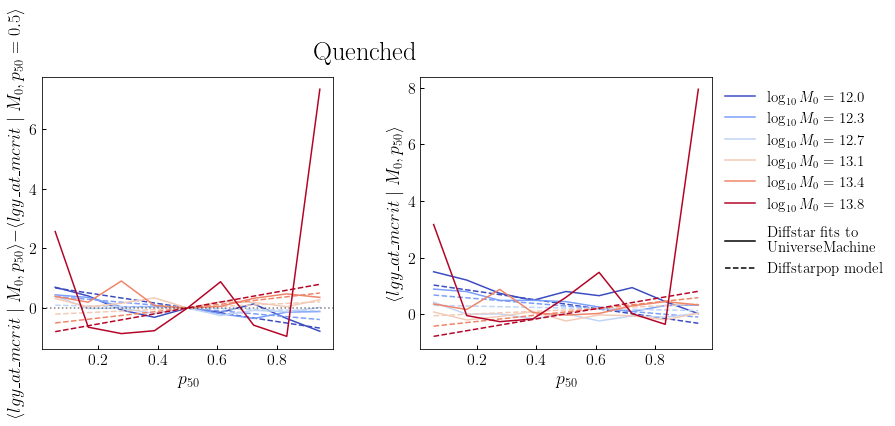

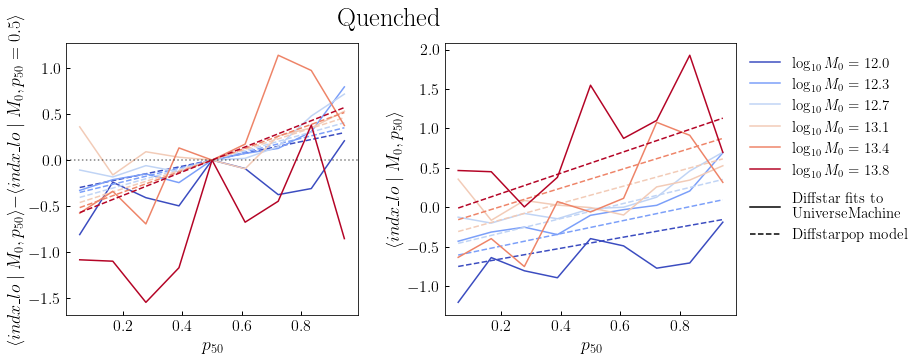

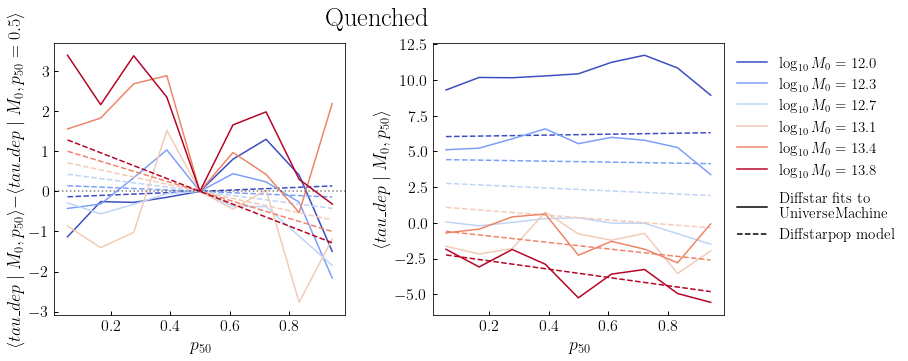

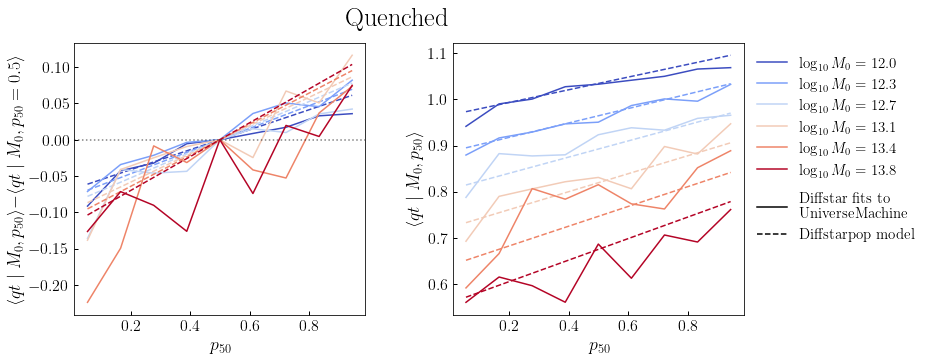

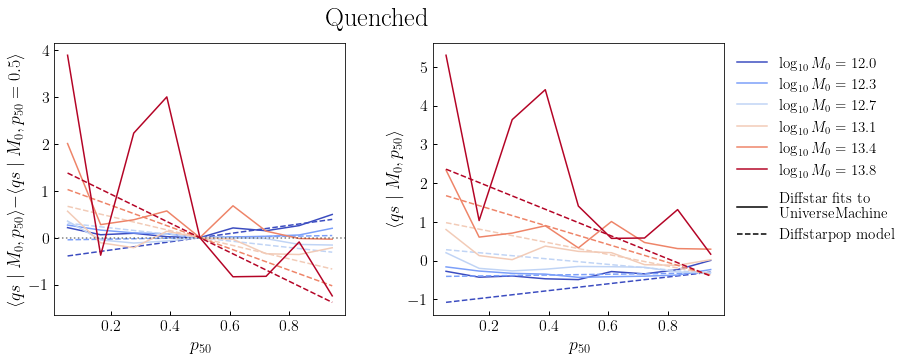

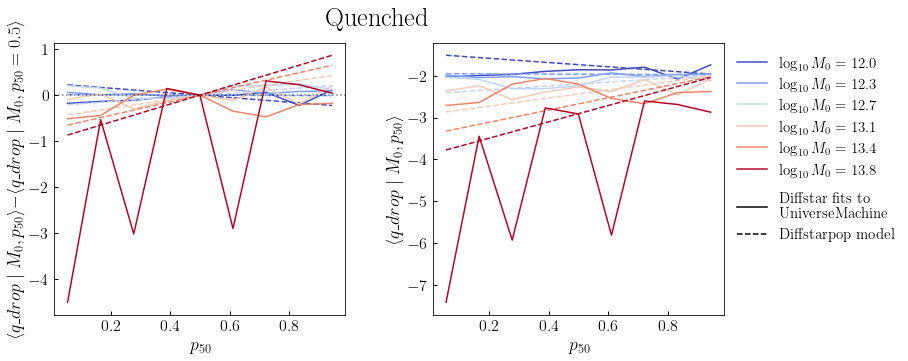

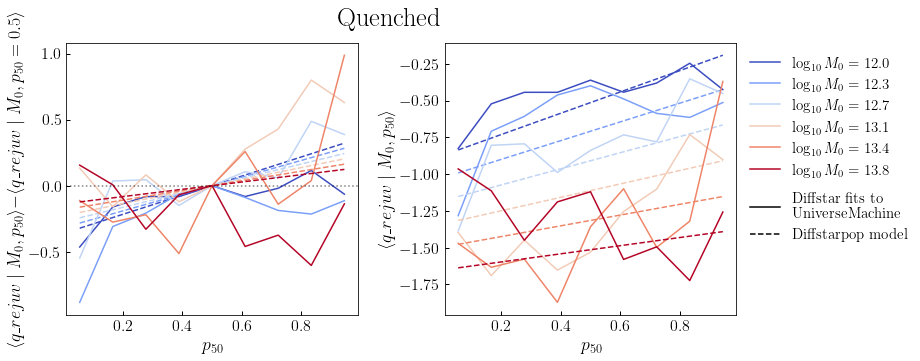

In [336]:
param_labels = [x.replace('_','\_') for x in sfr_colnames]
param_labels += [x.replace('_','\_') for x in q_colnames]


#_paramid = 5

for _paramid in [0,1,2,4,5,6,7,8]:

    fig, ax= plt.subplots(1, 2, figsize=(12,5))


    cmap = plt.get_cmap('coolwarm')
    for _i in range(len(massvalsc_p50_Q)):
        _color = cmap(float(_i)/(len(massvalsc_p50_Q)-1))
        ax[0].plot(p50_binsc, medians_p50_Q[_i, :, _paramid]- medians_p50_Q[_i, int(len(p50_bins)/2)-1, _paramid], color = _color)
        ax[1].plot(p50_binsc, medians_p50_Q[_i, :, _paramid], color = _color)

        param_p50_shift_curve = _fun_R(p50_binsc, _fun(massvalsc_p50_Q[_i], *Rval_lims_Q[:,_paramid]))
        if _paramid==0:
            param_m0_trend = _fun_Mcrit(massvalsc_p50_Q[_i], *median_lims_Q[:,_paramid])
        else:
            param_m0_trend = _fun(massvalsc_p50_Q[_i], *median_lims_Q[:,_paramid])

        ax[0].plot(p50_binsc, param_p50_shift_curve, ls='--', color = _color)
        #ax[1].plot(p50_binsc, np.ones_like(p50_binsc)*_fun(massvalsc_p50_Q[_i], *median_lims_Q[:,_paramid]), ls='--', color = _color)
        ax[1].plot(p50_binsc, param_m0_trend + param_p50_shift_curve, ls='--', color = _color)


    ax[0].set_xlabel(r"$p_{50}$")
    ax[1].set_xlabel(r"$p_{50}$")
    ax[0].set_ylabel(r"$\langle %s \mid M_{0}, p_{50}\rangle $"%param_labels[_paramid] + r"$ - \langle %s \mid M_{0}, p_{50}=0.5\rangle $"%param_labels[_paramid])
    ax[1].set_ylabel(r"$\langle %s \mid M_{0}, p_{50}\rangle $"%param_labels[_paramid])
    legend_elements = [
        Line2D([0], [0], color = cmap(float(i)/(len(massvalsc_p50_Q)-1)), ls='-', 
               label='$\log_{10} M_{0} = %.1f$'%massvalsc_p50_Q[i])
        for i in range(len(massvalsc_p50_Q)) 
               ]

    legend1 = ax[1].legend(handles=legend_elements, loc=2, ncol=1, bbox_to_anchor=(1.,1.))

    legend_elements = [
        Line2D([0], [0], color = 'k', ls='-', 
               label="Diffstar fits to \nUniverseMachine"),
        Line2D([0], [0], color = 'k', ls='--', 
               label="Diffstarpop model"),
               ]

    legend2 = ax[1].legend(handles=legend_elements, loc=2, ncol=1, bbox_to_anchor=(1.,0.5))

    ax[1].add_artist(legend1)

    ax[0].axhline(0.0, ls=":", alpha=0.5, color='k')
    fig.suptitle("Quenched")

    fig.subplots_adjust(wspace=0.3)
    plt.savefig("average_Q_%s_p50_M0.png"%names[_paramid], bbox_inches='tight', dpi=300)
    plt.show()

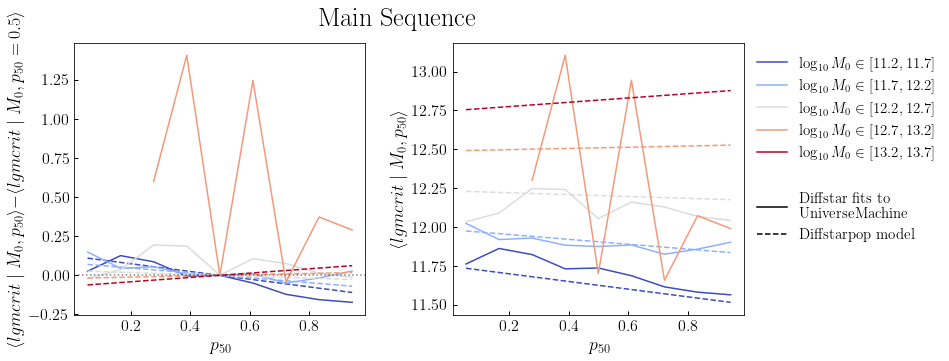

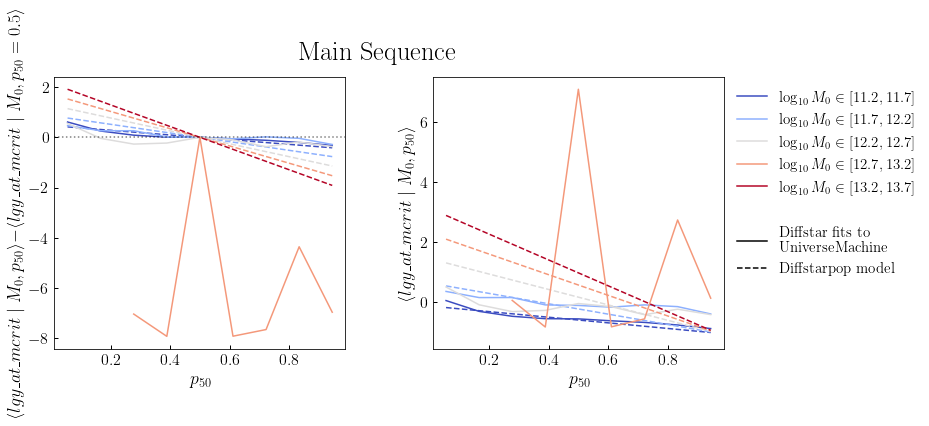

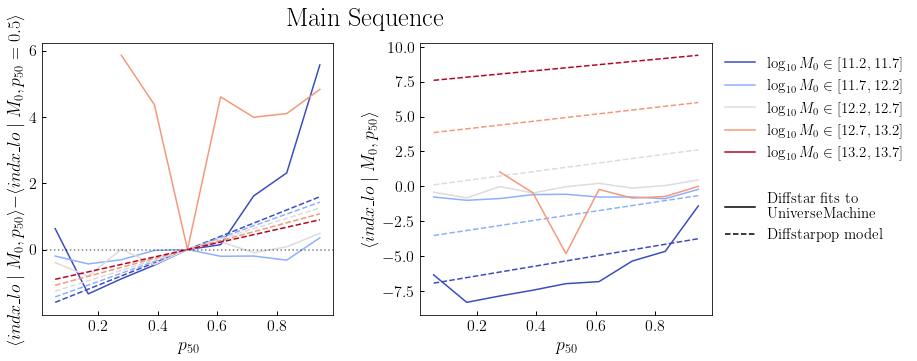

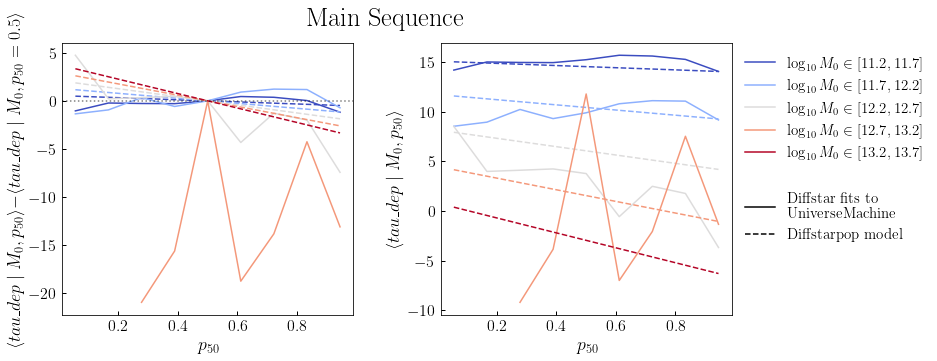

In [329]:
param_labels = [x.replace('_','\_') for x in sfr_colnames]
param_labels += [x.replace('_','\_') for x in q_colnames]


#_paramid = 5

for _paramid in [0,1,2,4]:

    fig, ax= plt.subplots(1, 2, figsize=(12,5))


    cmap = plt.get_cmap('coolwarm')
    for _i in range(len(massvalsc_p50_MS)):
        _color = cmap(float(_i)/(len(massvalsc_p50_MS)-1))
        ax[0].plot(p50_binsc, medians_p50_MS[_i, :, _paramid]- medians_p50_MS[_i, int(len(p50_bins)/2)-1, _paramid], color = _color)
        ax[1].plot(p50_binsc, medians_p50_MS[_i, :, _paramid], color = _color)

        param_p50_shift_curve = _fun_R(p50_binsc, _fun(massvalsc_p50_MS[_i], *Rval_lims_MS[:,_paramid]))
        param_m0_trend = _fun(massvalsc_p50_MS[_i], *median_lims_MS[:,_paramid])

        ax[0].plot(p50_binsc, param_p50_shift_curve, ls='--', color = _color)
        #ax[1].plot(p50_binsc, np.ones_like(p50_binsc)*_fun(massvalsc_p50_MS[_i], *median_lims_MS[:,_paramid]), ls='--', color = _color)
        ax[1].plot(p50_binsc, param_m0_trend + param_p50_shift_curve, ls='--', color = _color)


    ax[0].set_xlabel(r"$p_{50}$")
    ax[1].set_xlabel(r"$p_{50}$")
    ax[0].set_ylabel(r"$\langle %s \mid M_{0}, p_{50}\rangle $"%param_labels[_paramid] + r"$ - \langle %s \mid M_{0}, p_{50}=0.5\rangle $"%param_labels[_paramid])
    ax[1].set_ylabel(r"$\langle %s \mid M_{0}, p_{50}\rangle $"%param_labels[_paramid])
    legend_elements = [
        Line2D([0], [0], color = cmap(float(i)/(len(massvalsc_p50_MS)-1)), ls='-', 
               label='$\log_{10} M_{0} \in [%.1f, %.1f]$'%(massvals_p50[i],massvals_p50[i+1]))
        for i in range(len(massvalsc_p50_MS)) 
               ]

    legend1 = ax[1].legend(handles=legend_elements, loc=2, ncol=1, bbox_to_anchor=(1.,1.))

    legend_elements = [
        Line2D([0], [0], color = 'k', ls='-', 
               label="Diffstar fits to \nUniverseMachine"),
        Line2D([0], [0], color = 'k', ls='--', 
               label="Diffstarpop model"),
               ]

    legend2 = ax[1].legend(handles=legend_elements, loc=2, ncol=1, bbox_to_anchor=(1.,0.5))

    ax[1].add_artist(legend1)

    ax[0].axhline(0.0, ls=":", alpha=0.5, color='k')
    fig.suptitle("Main Sequence")

    fig.subplots_adjust(wspace=0.3)
    plt.savefig("average_MS_%s_p50_M0.png"%names[_paramid], bbox_inches='tight', dpi=300)
    plt.show()

# Creating strings for code QUENCHED

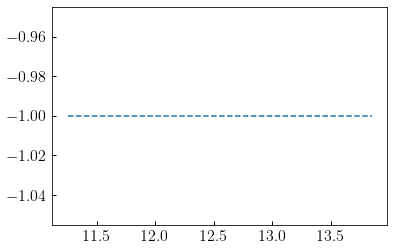

In [54]:
cov_lims_Q = np.zeros((2,9,9))
    
_bla = np.log10(np.ones_like(massvalsc)*0.1)
for i in _free_params:
    _res = curve_fit(_fun_cov_diag, massvalsc, _bla, 
                     p0 = [_bla[0], _bla[-1]], sigma=1.0/fquench[_mask])
    cov_lims_Q[:,i,i] = _res[0]  
    
plt.plot(massvalsc, _fun_cov_diag(massvalsc, *cov_lims_Q[:,0,0]), ls='--', color = line.get_color())


In [47]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

print("DEFAULT_SFH_PDF_QUENCH_PARAMS = OrderedDict(")

print(f"    frac_quench_x0={median_lims_fquenc[0]:.2f},")
print(f"    frac_quench_k={median_lims_fquenc[1]:.2f},")
print(f"    frac_quench_ylo={median_lims_fquenc[2]:.2f},")
print(f"    frac_quench_yhi={median_lims_fquenc[3]:.2f},")


for i in _free_params:
    print(f"    mean_{names[i]}_quench_ylo={median_lims_Q[0,i]:.2f},")
    print(f"    mean_{names[i]}_quench_yhi={median_lims_Q[1,i]:.2f},")


for i in _free_params:
    print(f"    cov_{names[i]}_{names[i]}_quench_ylo={cov_lims_Q[0,i,i]:.2f},")
    print(f"    cov_{names[i]}_{names[i]}_quench_yhi={cov_lims_Q[1,i,i]:.2f},")
            
for i in _free_params:
    for j in _free_params:
        if i>j:
            print(f"    cov_{names[i]}_{names[j]}_quench_ylo={cov_lims_Q[0,i,j]:.2f},")
            print(f"    cov_{names[i]}_{names[j]}_quench_yhi={cov_lims_Q[1,i,j]:.2f},")
print(")")          


DEFAULT_SFH_PDF_QUENCH_PARAMS = OrderedDict(
    frac_quench_x0=12.06,
    frac_quench_k=1.27,
    frac_quench_ylo=-0.81,
    frac_quench_yhi=1.78,
    mean_ulgm_quench_ylo=11.75,
    mean_ulgm_quench_yhi=12.32,
    mean_ulgy_quench_ylo=0.96,
    mean_ulgy_quench_yhi=-0.63,
    mean_ul_quench_ylo=-2.23,
    mean_ul_quench_yhi=2.48,
    mean_utau_quench_ylo=23.20,
    mean_utau_quench_yhi=-21.89,
    mean_uqt_quench_ylo=1.67,
    mean_uqt_quench_yhi=-0.01,
    mean_uqs_quench_ylo=-3.61,
    mean_uqs_quench_yhi=4.13,
    mean_udrop_quench_ylo=0.33,
    mean_udrop_quench_yhi=-5.13,
    mean_urej_quench_ylo=1.24,
    mean_urej_quench_yhi=-3.41,
    cov_ulgm_ulgm_quench_ylo=-0.12,
    cov_ulgm_ulgm_quench_yhi=-0.94,
    cov_ulgy_ulgy_quench_ylo=0.40,
    cov_ulgy_ulgy_quench_yhi=-1.29,
    cov_ul_ul_quench_ylo=0.20,
    cov_ul_ul_quench_yhi=-0.21,
    cov_utau_utau_quench_ylo=0.88,
    cov_utau_utau_quench_yhi=0.28,
    cov_uqt_uqt_quench_ylo=-0.05,
    cov_uqt_uqt_quench_yhi=-1.81,
    cov

In [193]:
print("def _get_cov_scalar(")
for i in _free_params:
    print(f"    {names[i]}_{names[i]},")
#print("")
for id_i, i in enumerate(_free_params):
    for id_j, j in enumerate(_free_params):
        if i>j:
            print(f"    {names[i]}_{names[j]},")
print("):")
print("    cov = jnp.zeros((8, 8)).astype('f4')")
for id_i, i in enumerate(_free_params):
    print(f"    cov = cov.at[({id_i}, {id_i})].set({names[i]}_{names[i]}**2)")
    
            
print("")
for id_i, i in enumerate(_free_params):
    for id_j, j in enumerate(_free_params):
        if id_i > id_j:
            #print(f"{names[i]}_{names[j]},")
            print(f"    cov = cov.at[({id_i}, {id_j})].set({names[i]}_{names[j]} * {names[i]}_{names[i]} * {names[j]}_{names[j]})")
            print(f"    cov = cov.at[({id_j}, {id_i})].set({names[i]}_{names[j]} * {names[i]}_{names[i]} * {names[j]}_{names[j]})")

print("    return cov")

def _get_cov_scalar(
    ulgm_ulgm,
    ulgy_ulgy,
    ul_ul,
    utau_utau,
    uqt_uqt,
    uqs_uqs,
    udrop_udrop,
    urej_urej,
    ulgy_ulgm,
    ul_ulgm,
    ul_ulgy,
    utau_ulgm,
    utau_ulgy,
    utau_ul,
    uqt_ulgm,
    uqt_ulgy,
    uqt_ul,
    uqt_utau,
    uqs_ulgm,
    uqs_ulgy,
    uqs_ul,
    uqs_utau,
    uqs_uqt,
    udrop_ulgm,
    udrop_ulgy,
    udrop_ul,
    udrop_utau,
    udrop_uqt,
    udrop_uqs,
    urej_ulgm,
    urej_ulgy,
    urej_ul,
    urej_utau,
    urej_uqt,
    urej_uqs,
    urej_udrop,
):
    cov = jnp.zeros((8, 8)).astype('f4')
    cov = cov.at[(0, 0)].set(ulgm_ulgm**2)
    cov = cov.at[(1, 1)].set(ulgy_ulgy**2)
    cov = cov.at[(2, 2)].set(ul_ul**2)
    cov = cov.at[(3, 3)].set(utau_utau**2)
    cov = cov.at[(4, 4)].set(uqt_uqt**2)
    cov = cov.at[(5, 5)].set(uqs_uqs**2)
    cov = cov.at[(6, 6)].set(udrop_udrop**2)
    cov = cov.at[(7, 7)].set(urej_urej**2)

    cov = cov.at[(1, 0)].set(ulgy_ulgm * ulgy_ulgy * ulgm_ulgm)
    cov = cov.at[(0

    elif i==5:
        print(
    f"""
@jjit
def mean_{names[i]}_quench_vs_lgm0(
    lgm0,
    mean_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_ylo"],
    mean_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_yhi"],
):
    return _fun_QT(lgm0, mean_{names[i]}_quench_ylo, mean_{names[i]}_quench_yhi)
    """  
        )

In [66]:
for i in _free_params:
    if i==0:
        print(
    f"""
@jjit
def mean_{names[i]}_quench_vs_lgm0(
    lgm0,
    mean_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_ylo"],
    mean_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_yhi"],
):
    return _fun_Mcrit(lgm0, mean_{names[i]}_quench_ylo, mean_{names[i]}_quench_yhi)
    """  
        )
    

    else:
        print(
    f"""
@jjit
def mean_{names[i]}_quench_vs_lgm0(
    lgm0,
    mean_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_ylo"],
    mean_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_yhi"],
):
    return _fun(lgm0, mean_{names[i]}_quench_ylo, mean_{names[i]}_quench_yhi)
    """  
        )


@jjit
def mean_ulgm_quench_vs_lgm0(
    lgm0,
    mean_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_ylo"],
    mean_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_yhi"],
):
    return _fun_Mcrit(lgm0, mean_ulgm_quench_ylo, mean_ulgm_quench_yhi)
    

@jjit
def mean_ulgy_quench_vs_lgm0(
    lgm0,
    mean_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_ylo"],
    mean_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_yhi"],
):
    return _fun(lgm0, mean_ulgy_quench_ylo, mean_ulgy_quench_yhi)
    

@jjit
def mean_ul_quench_vs_lgm0(
    lgm0,
    mean_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_ylo"],
    mean_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_yhi"],
):
    return _fun(lgm0, mean_ul_quench_ylo, mean_ul_quench_yhi)
    

@jjit
def mean_utau_quench_vs_lgm0(
    lgm0,
    mean_utau_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_utau_quench_ylo"],
    mean_utau_quench_yhi=DEFAULT_SFH_P

In [24]:
for i in _free_params:  
    print(
f"""

@jjit
def cov_{names[i]}_{names[i]}_quench_vs_lgm0(
    lgm0,
    cov_{names[i]}_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_ylo"],
    cov_{names[i]}_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_{names[i]}_{names[i]}_quench_ylo, cov_{names[i]}_{names[i]}_quench_yhi)
    return _res"""  
    )
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
f"""

@jjit
def cov_{names[i]}_{names[j]}_quench_vs_lgm0(
    lgm0,
    cov_{names[i]}_{names[j]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_ylo"],
    cov_{names[i]}_{names[j]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_yhi"],
):
    _res = _fun(lgm0, cov_{names[i]}_{names[j]}_quench_ylo, cov_{names[i]}_{names[j]}_quench_yhi)
    return _bound_cov_offdiag(_res)"""  
            )



@jjit
def cov_ulgm_ulgm_quench_vs_lgm0(
    lgm0,
    cov_ulgm_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_ylo"],
    cov_ulgm_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ulgm_ulgm_quench_ylo, cov_ulgm_ulgm_quench_yhi)
    return _res


@jjit
def cov_ulgy_ulgy_quench_vs_lgm0(
    lgm0,
    cov_ulgy_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_ylo"],
    cov_ulgy_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ulgy_ulgy_quench_ylo, cov_ulgy_ulgy_quench_yhi)
    return _res


@jjit
def cov_ul_ul_quench_vs_lgm0(
    lgm0,
    cov_ul_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_ylo"],
    cov_ul_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ul_ul_quench_ylo, cov_ul_ul_quench_yhi)
    return _res


@jjit
def cov_utau_utau_quench_vs_lg

In [123]:
print("""
def get_default_params(lgm):
    frac_quench = frac_quench_vs_lgm0(lgm)""")
    
for i in _free_params:
    print(f"""    {names[i]}_q = mean_{names[i]}_quench_vs_lgm0(lgm)""")

for i in _free_params:
    print(f"""    {names[i]}_{names[i]}_q = cov_{names[i]}_{names[i]}_quench_vs_lgm0(lgm)""")

for i in _free_params:
    for j in _free_params:
        if i>j: 
            print(f"""    {names[i]}_{names[j]}_q = cov_{names[i]}_{names[j]}_quench_vs_lgm0(lgm)""")
            
            
print("""    
    all_params = (
        frac_quench,""")
for i in _free_params:
    print(f"""        {names[i]}_q,""")
    
for i in _free_params:
    print(f"""        {names[i]}_{names[i]}_q,""")    
for i in _free_params:
    for j in _free_params:
        if i>j: 
            print(f"""        {names[i]}_{names[j]}_q,""")
            
print("""    )
    return all_params
""")


def get_default_params(lgm):
    frac_quench = frac_quench_vs_lgm0(lgm)
    ulgm_q = mean_ulgm_quench_vs_lgm0(lgm)
    ulgy_q = mean_ulgy_quench_vs_lgm0(lgm)
    ul_q = mean_ul_quench_vs_lgm0(lgm)
    utau_q = mean_utau_quench_vs_lgm0(lgm)
    uqt_q = mean_uqt_quench_vs_lgm0(lgm)
    uqs_q = mean_uqs_quench_vs_lgm0(lgm)
    udrop_q = mean_udrop_quench_vs_lgm0(lgm)
    urej_q = mean_urej_quench_vs_lgm0(lgm)
    ulgm_ulgm_q = cov_ulgm_ulgm_quench_vs_lgm0(lgm)
    ulgy_ulgy_q = cov_ulgy_ulgy_quench_vs_lgm0(lgm)
    ul_ul_q = cov_ul_ul_quench_vs_lgm0(lgm)
    utau_utau_q = cov_utau_utau_quench_vs_lgm0(lgm)
    uqt_uqt_q = cov_uqt_uqt_quench_vs_lgm0(lgm)
    uqs_uqs_q = cov_uqs_uqs_quench_vs_lgm0(lgm)
    udrop_udrop_q = cov_udrop_udrop_quench_vs_lgm0(lgm)
    urej_urej_q = cov_urej_urej_quench_vs_lgm0(lgm)
    ulgy_ulgm_q = cov_ulgy_ulgm_quench_vs_lgm0(lgm)
    ul_ulgm_q = cov_ul_ulgm_quench_vs_lgm0(lgm)
    ul_ulgy_q = cov_ul_ulgy_quench_vs_lgm0(lgm)
    utau_ulgm_q = cov_utau_ulgm_quenc

In [159]:
print("""
@jjit
def _get_smah_means_and_covs(
    logmp_arr,""")

print("""    frac_quench_x0=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_x0"],
    frac_quench_k=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_k"],
    frac_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_ylo"],
    frac_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_yhi"],""")

for i in _free_params:
    print(
    f"""    mean_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_ylo"],
    mean_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_yhi"],""")
    
for i in _free_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_ylo"],
    cov_{names[i]}_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_yhi"],"""  
    )
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_ylo"],
    cov_{names[i]}_{names[j]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_yhi"],"""  
            )
print("""):""")

print("""
    frac_quench = frac_quench_vs_lgm0(logmp_arr, frac_quench_x0, frac_quench_k, frac_quench_ylo, frac_quench_yhi)
    _res = _get_mean_smah_params_quench(
        logmp_arr,""")
for i in _free_params:
    print(
    f"""        mean_{names[i]}_quench_ylo,
        mean_{names[i]}_quench_yhi,""") 
print("""    )""")

print("""
    means_quench = jnp.array(_res).T

    covs_quench = _get_covs_quench(
        logmp_arr,""")

for i in _free_params:  
    print(
    f"""        cov_{names[i]}_{names[i]}_quench_ylo,
        cov_{names[i]}_{names[i]}_quench_yhi,""")
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
    f"""        cov_{names[i]}_{names[j]}_quench_ylo,
        cov_{names[i]}_{names[j]}_quench_yhi,"""  
            )
print("""    )
    return frac_quench, means_quench, covs_quench""")



@jjit
def _get_smah_means_and_covs(
    logmp_arr,
    frac_quench_x0=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_x0"],
    frac_quench_k=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_k"],
    frac_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_ylo"],
    frac_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["frac_quench_yhi"],
    mean_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_ylo"],
    mean_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_yhi"],
    mean_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_ylo"],
    mean_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_yhi"],
    mean_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_ylo"],
    mean_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_yhi"],
    mean_utau_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_utau_quench_ylo"],
    mean_utau_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_utau_quench_yhi"],
    mean_uqt_quench_ylo=DEFAULT_SFH_PDF_QU

In [169]:
print("""@jjit
def _get_mean_smah_params_quench(
    lgm,""")
for i in _free_params:
    print(
    f"""    mean_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_ylo"],
    mean_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_{names[i]}_quench_yhi"],""")
print("""):""")

for i in _free_params:
    print(
    f"""    {names[i]} = mean_{names[i]}_quench_vs_lgm0(lgm, mean_{names[i]}_quench_ylo, mean_{names[i]}_quench_yhi)"""  
    )
print("""    return """ + ", ".join([names[i] for i in _free_params]))

@jjit
def _get_mean_smah_params_quench(
    lgm,
    mean_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_ylo"],
    mean_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgm_quench_yhi"],
    mean_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_ylo"],
    mean_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ulgy_quench_yhi"],
    mean_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_ylo"],
    mean_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_ul_quench_yhi"],
    mean_utau_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_utau_quench_ylo"],
    mean_utau_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_utau_quench_yhi"],
    mean_uqt_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_uqt_quench_ylo"],
    mean_uqt_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_uqt_quench_yhi"],
    mean_uqs_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_uqs_quench_ylo"],
    mean_uqs_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["mean_uqs_quench_yhi"],
    mea

In [176]:
print("""@jjit
def _get_covs_quench(
    lgmp_arr,""")

for i in _free_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_ylo"],
    cov_{names[i]}_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_yhi"],"""  
    )
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_ylo"],
    cov_{names[i]}_{names[j]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_yhi"],"""  
            )
print("""):""")

print("""
    _res = _get_cov_params_quench(
        lgmp_arr,""")
for i in _free_params: 
    print(
    f"""        cov_{names[i]}_{names[i]}_quench_ylo,
        cov_{names[i]}_{names[i]}_quench_yhi,"""
    )
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
        f"""        cov_{names[i]}_{names[j]}_quench_ylo,
        cov_{names[i]}_{names[j]}_quench_yhi,""" 
            )
print("""    )
    return _get_cov_vmap(*_res)
""")


@jjit
def _get_covs_quench(
    lgmp_arr,
    cov_ulgm_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_ylo"],
    cov_ulgm_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_yhi"],
    cov_ulgy_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_ylo"],
    cov_ulgy_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_yhi"],
    cov_ul_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_ylo"],
    cov_ul_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_yhi"],
    cov_utau_utau_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_utau_utau_quench_ylo"],
    cov_utau_utau_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_utau_utau_quench_yhi"],
    cov_uqt_uqt_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqt_uqt_quench_ylo"],
    cov_uqt_uqt_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqt_uqt_quench_yhi"],
    cov_uqs_uqs_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqs_uqs_quench_ylo"],
    cov_uqs_uqs_qu

In [191]:
print("""@jjit
def _get_cov_params_quench(
    lgm,""")

for i in _free_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_ylo"],
    cov_{names[i]}_{names[i]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[i]}_quench_yhi"],"""  
    )
    
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_ylo"],
    cov_{names[i]}_{names[j]}_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_{names[i]}_{names[j]}_quench_yhi"],"""  
            )
print("""):""")

for i in _free_params:
    print(
    f"""    {names[i]}_{names[i]} = cov_{names[i]}_{names[i]}_quench_vs_lgm0(lgm, cov_{names[i]}_{names[i]}_quench_ylo, cov_{names[i]}_{names[i]}_quench_yhi)"""  
    )
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
            f"""    {names[i]}_{names[j]} = cov_{names[i]}_{names[j]}_quench_vs_lgm0(lgm, cov_{names[i]}_{names[j]}_quench_ylo, cov_{names[i]}_{names[j]}_quench_yhi)"""  
            )
            
print("""
    cov_params = (""")
for i in _free_params: 
    print(
    f"""        {names[i]}_{names[i]},"""
    )
for i in _free_params:
    for j in _free_params:
        if i>j:    
            print(
            f"""        {names[i]}_{names[j]},"""
            )
print("""    )

    return cov_params
    """)

@jjit
def _get_cov_params_quench(
    lgm,
    cov_ulgm_ulgm_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_ylo"],
    cov_ulgm_ulgm_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgm_ulgm_quench_yhi"],
    cov_ulgy_ulgy_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_ylo"],
    cov_ulgy_ulgy_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ulgy_ulgy_quench_yhi"],
    cov_ul_ul_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_ylo"],
    cov_ul_ul_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_ul_ul_quench_yhi"],
    cov_utau_utau_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_utau_utau_quench_ylo"],
    cov_utau_utau_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_utau_utau_quench_yhi"],
    cov_uqt_uqt_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqt_uqt_quench_ylo"],
    cov_uqt_uqt_quench_yhi=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqt_uqt_quench_yhi"],
    cov_uqs_uqs_quench_ylo=DEFAULT_SFH_PDF_QUENCH_PARAMS["cov_uqs_uqs_quench_ylo"],
    cov_uqs_uqs_q

# Creating strings for code MAIN SEQ

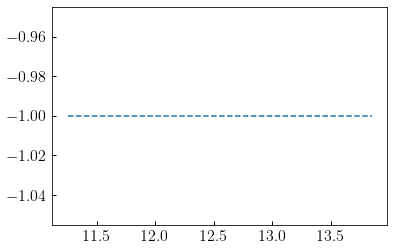

In [49]:
cov_lims_MS = np.zeros((2,9,9))
    
_bla = np.log10(np.ones_like(massvalsc)*0.1)
for i in _free_params:
    _res = curve_fit(_fun_cov_diag, massvalsc, _bla, 
                     p0 = [_bla[0], _bla[-1]])
    cov_lims_MS[:,i,i] = _res[0]  
    
plt.plot(massvalsc, _fun_cov_diag(massvalsc, *cov_lims_MS[:,0,0]), ls='--', color = line.get_color())


In [48]:
names = ["ulgm", "ulgy", "ul", "uh", "utau", "uqt", "uqs", "udrop", "urej"]

print("DEFAULT_SFH_PDF_MAINSEQ_PARAMS = OrderedDict(")

for i in _ms_params:
    print(f"    mean_{names[i]}_mainseq_ylo={median_lims_MS[0,i]:.2f},")
    print(f"    mean_{names[i]}_mainseq_yhi={median_lims_MS[1,i]:.2f},")


for i in _ms_params:
    print(f"    cov_{names[i]}_{names[i]}_mainseq_ylo={cov_lims_MS[0,i,i]:.2f},")
    print(f"    cov_{names[i]}_{names[i]}_mainseq_yhi={cov_lims_MS[1,i,i]:.2f},")
            
for i in _ms_params:
    for j in _ms_params:
        if i>j:
            print(f"    cov_{names[i]}_{names[j]}_mainseq_ylo={cov_lims_MS[0,i,j]:.2f},")
            print(f"    cov_{names[i]}_{names[j]}_mainseq_yhi={cov_lims_MS[1,i,j]:.2f},")
print(")")          


DEFAULT_SFH_PDF_MAINSEQ_PARAMS = OrderedDict(
    mean_ulgm_mainseq_ylo=10.04,
    mean_ulgm_mainseq_yhi=14.98,
    mean_ulgy_mainseq_ylo=-2.69,
    mean_ulgy_mainseq_yhi=3.83,
    mean_ul_mainseq_ylo=-23.74,
    mean_ul_mainseq_yhi=33.59,
    mean_utau_mainseq_ylo=37.79,
    mean_utau_mainseq_yhi=-34.69,
    cov_ulgm_ulgm_mainseq_ylo=0.12,
    cov_ulgm_ulgm_mainseq_yhi=-1.30,
    cov_ulgy_ulgy_mainseq_ylo=-0.55,
    cov_ulgy_ulgy_mainseq_yhi=-0.12,
    cov_ul_ul_mainseq_ylo=2.16,
    cov_ul_ul_mainseq_yhi=-2.22,
    cov_utau_utau_mainseq_ylo=0.14,
    cov_utau_utau_mainseq_yhi=1.53,
    cov_ulgy_ulgm_mainseq_ylo=-0.00,
    cov_ulgy_ulgm_mainseq_yhi=-0.04,
    cov_ul_ulgm_mainseq_ylo=0.15,
    cov_ul_ulgm_mainseq_yhi=-0.51,
    cov_ul_ulgy_mainseq_ylo=-0.06,
    cov_ul_ulgy_mainseq_yhi=0.10,
    cov_utau_ulgm_mainseq_ylo=0.04,
    cov_utau_ulgm_mainseq_yhi=-0.06,
    cov_utau_ulgy_mainseq_ylo=-0.17,
    cov_utau_ulgy_mainseq_yhi=0.70,
    cov_utau_ul_mainseq_ylo=-0.04,
    cov_utau_ul_

In [54]:
print("def _get_cov_scalar(")
for i in _ms_params:
    print(f"    {names[i]}_{names[i]},")
#print("")
for id_i, i in enumerate(_ms_params):
    for id_j, j in enumerate(_ms_params):
        if i>j:
            print(f"    {names[i]}_{names[j]},")
print("):")
print("    cov = jnp.zeros((4, 4)).astype('f4')")
for id_i, i in enumerate(_ms_params):
    print(f"    cov = cov.at[({id_i}, {id_i})].set({names[i]}_{names[i]}**2)")
    
            
print("")
for id_i, i in enumerate(_ms_params):
    for id_j, j in enumerate(_ms_params):
        if id_i > id_j:
            #print(f"{names[i]}_{names[j]},")
            print(f"    cov = cov.at[({id_i}, {id_j})].set({names[i]}_{names[j]} * {names[i]}_{names[i]} * {names[j]}_{names[j]})")
            print(f"    cov = cov.at[({id_j}, {id_i})].set({names[i]}_{names[j]} * {names[i]}_{names[i]} * {names[j]}_{names[j]})")

print("    return cov")

def _get_cov_scalar(
    ulgm_ulgm,
    ulgy_ulgy,
    ul_ul,
    utau_utau,
    ulgy_ulgm,
    ul_ulgm,
    ul_ulgy,
    utau_ulgm,
    utau_ulgy,
    utau_ul,
):
    cov = jnp.zeros((4, 4)).astype('f4')
    cov = cov.at[(0, 0)].set(ulgm_ulgm**2)
    cov = cov.at[(1, 1)].set(ulgy_ulgy**2)
    cov = cov.at[(2, 2)].set(ul_ul**2)
    cov = cov.at[(3, 3)].set(utau_utau**2)

    cov = cov.at[(1, 0)].set(ulgy_ulgm * ulgy_ulgy * ulgm_ulgm)
    cov = cov.at[(0, 1)].set(ulgy_ulgm * ulgy_ulgy * ulgm_ulgm)
    cov = cov.at[(2, 0)].set(ul_ulgm * ul_ul * ulgm_ulgm)
    cov = cov.at[(0, 2)].set(ul_ulgm * ul_ul * ulgm_ulgm)
    cov = cov.at[(2, 1)].set(ul_ulgy * ul_ul * ulgy_ulgy)
    cov = cov.at[(1, 2)].set(ul_ulgy * ul_ul * ulgy_ulgy)
    cov = cov.at[(3, 0)].set(utau_ulgm * utau_utau * ulgm_ulgm)
    cov = cov.at[(0, 3)].set(utau_ulgm * utau_utau * ulgm_ulgm)
    cov = cov.at[(3, 1)].set(utau_ulgy * utau_utau * ulgy_ulgy)
    cov = cov.at[(1, 3)].set(utau_ulgy * utau_utau * ulgy_ulgy)
    cov = 

    elif i==5:
        print(
    f"""
@jjit
def mean_{names[i]}_mainseq_vs_lgm0(
    lgm0,
    mean_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_ylo"],
    mean_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_yhi"],
):
    return _fun_MST(lgm0, mean_{names[i]}_mainseq_ylo, mean_{names[i]}_mainseq_yhi)
    """  
        )

In [56]:
for i in _ms_params:
    if i==10:
        print(
    f"""
@jjit
def mean_{names[i]}_mainseq_vs_lgm0(
    lgm0,
    mean_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_ylo"],
    mean_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_yhi"],
):
    return _fun_Mcrit(lgm0, mean_{names[i]}_mainseq_ylo, mean_{names[i]}_mainseq_yhi)
    """  
        )
    

    else:
        print(
    f"""
@jjit
def mean_{names[i]}_mainseq_vs_lgm0(
    lgm0,
    mean_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_ylo"],
    mean_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_yhi"],
):
    return _fun(lgm0, mean_{names[i]}_mainseq_ylo, mean_{names[i]}_mainseq_yhi)
    """  
        )


@jjit
def mean_ulgm_mainseq_vs_lgm0(
    lgm0,
    mean_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_ylo"],
    mean_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_yhi"],
):
    return _fun(lgm0, mean_ulgm_mainseq_ylo, mean_ulgm_mainseq_yhi)
    

@jjit
def mean_ulgy_mainseq_vs_lgm0(
    lgm0,
    mean_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_ylo"],
    mean_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_yhi"],
):
    return _fun(lgm0, mean_ulgy_mainseq_ylo, mean_ulgy_mainseq_yhi)
    

@jjit
def mean_ul_mainseq_vs_lgm0(
    lgm0,
    mean_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_ylo"],
    mean_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_yhi"],
):
    return _fun(lgm0, mean_ul_mainseq_ylo, mean_ul_mainseq_yhi)
    

@jjit
def mean_utau_mainseq_vs_lgm0(
    lgm0,
    mean_utau_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_utau_mainseq_ylo"],
    mean_utau

In [57]:
for i in _ms_params:  
    print(
f"""

@jjit
def cov_{names[i]}_{names[i]}_mainseq_vs_lgm0(
    lgm0,
    cov_{names[i]}_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_ylo"],
    cov_{names[i]}_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_{names[i]}_{names[i]}_mainseq_ylo, cov_{names[i]}_{names[i]}_mainseq_yhi)
    return _res"""  
    )
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
f"""

@jjit
def cov_{names[i]}_{names[j]}_mainseq_vs_lgm0(
    lgm0,
    cov_{names[i]}_{names[j]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_ylo"],
    cov_{names[i]}_{names[j]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_yhi"],
):
    _res = _fun(lgm0, cov_{names[i]}_{names[j]}_mainseq_ylo, cov_{names[i]}_{names[j]}_mainseq_yhi)
    return _bound_cov_offdiag(_res)"""  
            )



@jjit
def cov_ulgm_ulgm_mainseq_vs_lgm0(
    lgm0,
    cov_ulgm_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_ylo"],
    cov_ulgm_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ulgm_ulgm_mainseq_ylo, cov_ulgm_ulgm_mainseq_yhi)
    return _res


@jjit
def cov_ulgy_ulgy_mainseq_vs_lgm0(
    lgm0,
    cov_ulgy_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_ylo"],
    cov_ulgy_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ulgy_ulgy_mainseq_ylo, cov_ulgy_ulgy_mainseq_yhi)
    return _res


@jjit
def cov_ul_ul_mainseq_vs_lgm0(
    lgm0,
    cov_ul_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_ylo"],
    cov_ul_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_yhi"],
):
    _res = _fun_cov_diag(lgm0, cov_ul_ul_mainseq_ylo, cov_ul_ul_mainseq_yhi)
    return _res


@jjit
def

In [62]:
print("""
def get_default_params(lgm):
    """)
    
for i in _ms_params:
    print(f"""    {names[i]}_MS = mean_{names[i]}_mainseq_vs_lgm0(lgm)""")

for i in _ms_params:
    print(f"""    {names[i]}_{names[i]}_MS = cov_{names[i]}_{names[i]}_mainseq_vs_lgm0(lgm)""")

for i in _ms_params:
    for j in _ms_params:
        if i>j: 
            print(f"""    {names[i]}_{names[j]}_MS = cov_{names[i]}_{names[j]}_mainseq_vs_lgm0(lgm)""")
            
            
print("""    
    all_params = (""")
for i in _ms_params:
    print(f"""        {names[i]}_MS,""")
    
for i in _ms_params:
    print(f"""        {names[i]}_{names[i]}_MS,""")    
for i in _ms_params:
    for j in _ms_params:
        if i>j: 
            print(f"""        {names[i]}_{names[j]}_MS,""")
            
print("""    )
    return all_params
""")


def get_default_params(lgm):
    
    ulgm_MS = mean_ulgm_mainseq_vs_lgm0(lgm)
    ulgy_MS = mean_ulgy_mainseq_vs_lgm0(lgm)
    ul_MS = mean_ul_mainseq_vs_lgm0(lgm)
    utau_MS = mean_utau_mainseq_vs_lgm0(lgm)
    ulgm_ulgm_MS = cov_ulgm_ulgm_mainseq_vs_lgm0(lgm)
    ulgy_ulgy_MS = cov_ulgy_ulgy_mainseq_vs_lgm0(lgm)
    ul_ul_MS = cov_ul_ul_mainseq_vs_lgm0(lgm)
    utau_utau_MS = cov_utau_utau_mainseq_vs_lgm0(lgm)
    ulgy_ulgm_MS = cov_ulgy_ulgm_mainseq_vs_lgm0(lgm)
    ul_ulgm_MS = cov_ul_ulgm_mainseq_vs_lgm0(lgm)
    ul_ulgy_MS = cov_ul_ulgy_mainseq_vs_lgm0(lgm)
    utau_ulgm_MS = cov_utau_ulgm_mainseq_vs_lgm0(lgm)
    utau_ulgy_MS = cov_utau_ulgy_mainseq_vs_lgm0(lgm)
    utau_ul_MS = cov_utau_ul_mainseq_vs_lgm0(lgm)
    
    all_params = (
        ulgm_MS,
        ulgy_MS,
        ul_MS,
        utau_MS,
        ulgm_ulgm_MS,
        ulgy_ulgy_MS,
        ul_ul_MS,
        utau_utau_MS,
        ulgy_ulgm_MS,
        ul_ulgm_MS,
        ul_ulgy_MS,
        utau_ulgm_MS,
        uta

In [67]:
print("""
@jjit
def get_smah_means_and_covs_mainseq(
    logmp_arr,""")

for i in _ms_params:
    print(
    f"""    mean_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_ylo"],
    mean_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_yhi"],""")
    
for i in _ms_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_ylo"],
    cov_{names[i]}_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_yhi"],"""  
    )
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_ylo"],
    cov_{names[i]}_{names[j]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_yhi"],"""  
            )
print("""):""")

print("""
    _res = _get_mean_smah_params_mainseq(
        logmp_arr,""")
for i in _ms_params:
    print(
    f"""        mean_{names[i]}_mainseq_ylo,
        mean_{names[i]}_mainseq_yhi,""") 
print("""    )""")

print("""
    means_mainseq = jnp.array(_res).T

    covs_mainseq = _get_covs_mainseq(
        logmp_arr,""")

for i in _ms_params:  
    print(
    f"""        cov_{names[i]}_{names[i]}_mainseq_ylo,
        cov_{names[i]}_{names[i]}_mainseq_yhi,""")
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
    f"""        cov_{names[i]}_{names[j]}_mainseq_ylo,
        cov_{names[i]}_{names[j]}_mainseq_yhi,"""  
            )
print("""    )
    return means_mainseq, covs_mainseq""")



@jjit
def get_smah_means_and_covs_mainseq(
    logmp_arr,
    mean_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_ylo"],
    mean_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_yhi"],
    mean_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_ylo"],
    mean_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_yhi"],
    mean_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_ylo"],
    mean_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_yhi"],
    mean_utau_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_utau_mainseq_ylo"],
    mean_utau_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_utau_mainseq_yhi"],
    cov_ulgm_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_ylo"],
    cov_ulgm_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_yhi"],
    cov_ulgy_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_ylo"],
    cov_ulgy

In [68]:
print("""@jjit
def _get_mean_smah_params_mainseq(
    lgm,""")
for i in _ms_params:
    print(
    f"""    mean_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_ylo"],
    mean_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_{names[i]}_mainseq_yhi"],""")
print("""):""")

for i in _ms_params:
    print(
    f"""    {names[i]} = mean_{names[i]}_mainseq_vs_lgm0(lgm, mean_{names[i]}_mainseq_ylo, mean_{names[i]}_mainseq_yhi)"""  
    )
print("""    return """ + ", ".join([names[i] for i in _ms_params]))

@jjit
def _get_mean_smah_params_mainseq(
    lgm,
    mean_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_ylo"],
    mean_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgm_mainseq_yhi"],
    mean_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_ylo"],
    mean_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ulgy_mainseq_yhi"],
    mean_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_ylo"],
    mean_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_ul_mainseq_yhi"],
    mean_utau_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_utau_mainseq_ylo"],
    mean_utau_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["mean_utau_mainseq_yhi"],
):
    ulgm = mean_ulgm_mainseq_vs_lgm0(lgm, mean_ulgm_mainseq_ylo, mean_ulgm_mainseq_yhi)
    ulgy = mean_ulgy_mainseq_vs_lgm0(lgm, mean_ulgy_mainseq_ylo, mean_ulgy_mainseq_yhi)
    ul = mean_ul_mainseq_vs_lgm0(lgm, mean_ul_mainseq_ylo, mean_ul_mainseq_yhi)
    utau = mean_utau_mainseq_vs_lgm

In [69]:
print("""@jjit
def _get_covs_mainseq(
    lgmp_arr,""")

for i in _ms_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_ylo"],
    cov_{names[i]}_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_yhi"],"""  
    )
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_ylo"],
    cov_{names[i]}_{names[j]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_yhi"],"""  
            )
print("""):""")

print("""
    _res = _get_cov_params_mainseq(
        lgmp_arr,""")
for i in _ms_params: 
    print(
    f"""        cov_{names[i]}_{names[i]}_mainseq_ylo,
        cov_{names[i]}_{names[i]}_mainseq_yhi,"""
    )
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
        f"""        cov_{names[i]}_{names[j]}_mainseq_ylo,
        cov_{names[i]}_{names[j]}_mainseq_yhi,""" 
            )
print("""    )
    return _get_cov_vmap(*_res)
""")


@jjit
def _get_covs_mainseq(
    lgmp_arr,
    cov_ulgm_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_ylo"],
    cov_ulgm_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_yhi"],
    cov_ulgy_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_ylo"],
    cov_ulgy_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_yhi"],
    cov_ul_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_ylo"],
    cov_ul_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_yhi"],
    cov_utau_utau_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_utau_utau_mainseq_ylo"],
    cov_utau_utau_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_utau_utau_mainseq_yhi"],
    cov_ulgy_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgm_mainseq_ylo"],
    cov_ulgy_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgm_mainseq_yhi"],
    cov_ul_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov

In [70]:
print("""@jjit
def _get_cov_params_mainseq(
    lgm,""")

for i in _ms_params: 
    print(
    f"""    cov_{names[i]}_{names[i]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_ylo"],
    cov_{names[i]}_{names[i]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[i]}_mainseq_yhi"],"""  
    )
    
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
        f"""    cov_{names[i]}_{names[j]}_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_ylo"],
    cov_{names[i]}_{names[j]}_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_{names[i]}_{names[j]}_mainseq_yhi"],"""  
            )
print("""):""")

for i in _ms_params:
    print(
    f"""    {names[i]}_{names[i]} = cov_{names[i]}_{names[i]}_mainseq_vs_lgm0(lgm, cov_{names[i]}_{names[i]}_mainseq_ylo, cov_{names[i]}_{names[i]}_mainseq_yhi)"""  
    )
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
            f"""    {names[i]}_{names[j]} = cov_{names[i]}_{names[j]}_mainseq_vs_lgm0(lgm, cov_{names[i]}_{names[j]}_mainseq_ylo, cov_{names[i]}_{names[j]}_mainseq_yhi)"""  
            )
            
print("""
    cov_params = (""")
for i in _ms_params: 
    print(
    f"""        {names[i]}_{names[i]},"""
    )
for i in _ms_params:
    for j in _ms_params:
        if i>j:    
            print(
            f"""        {names[i]}_{names[j]},"""
            )
print("""    )

    return cov_params
    """)

@jjit
def _get_cov_params_mainseq(
    lgm,
    cov_ulgm_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_ylo"],
    cov_ulgm_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgm_ulgm_mainseq_yhi"],
    cov_ulgy_ulgy_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_ylo"],
    cov_ulgy_ulgy_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgy_mainseq_yhi"],
    cov_ul_ul_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_ylo"],
    cov_ul_ul_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ul_ul_mainseq_yhi"],
    cov_utau_utau_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_utau_utau_mainseq_ylo"],
    cov_utau_utau_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_utau_utau_mainseq_yhi"],
    cov_ulgy_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgm_mainseq_ylo"],
    cov_ulgy_ulgm_mainseq_yhi=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["cov_ulgy_ulgm_mainseq_yhi"],
    cov_ul_ulgm_mainseq_ylo=DEFAULT_SFH_PDF_MAINSEQ_PARAMS["co

# Creating strings for code MAH CORRELATIONS


In [373]:
print("""DEFAULT_R_QUENCH_PARAMS = OrderedDict(""")  

for i in _free_params:
    print(f"    R_{names[i]}_quench_ylo={Rval_lims_Q[0,i]:.2f},")
    print(f"    R_{names[i]}_quench_yhi={Rval_lims_Q[1,i]:.2f},")
print(""")""")
   
for i in _free_params:
    if i==0:
        print(
f"""

@jjit
def R_{names[i]}_quench_vs_lgm0(
    lgm0,
    R_{names[i]}_quench_ylo=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_ylo"],
    R_{names[i]}_quench_yhi=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_yhi"],
):
    return _fun_Mcrit(lgm0, R_{names[i]}_quench_ylo, R_{names[i]}_quench_yhi)"""  
        )
    else:
        print(
f"""

@jjit
def R_{names[i]}_quench_vs_lgm0(
    lgm0,
    R_{names[i]}_quench_ylo=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_ylo"],
    R_{names[i]}_quench_yhi=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_yhi"],
):
    return _sigmoid(lgm0, _LGM_X0, LGM_K, R_{names[i]}_quench_ylo, R_{names[i]}_quench_yhi)"""  
        )
    

print()

print("""@jjit
def _get_slopes_quench(
    lgm,""")    
for i in _free_params:
    print(
    f"""    R_{names[i]}_quench_ylo=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_ylo"],
    R_{names[i]}_quench_yhi=DEFAULT_R_QUENCH_PARAMS["R_{names[i]}_quench_yhi"],""")
    
print("""):""")

for i in _free_params:
    print(
    f"""    R_{names[i]} = R_{names[i]}_quench_vs_lgm0(lgm, R_{names[i]}_quench_ylo, R_{names[i]}_quench_yhi)"""  
    )
    
print("""
    slopes = ("""
)
for i in _free_params:
    print(
    f"""        R_{names[i]},"""  
    )
print("""    )

    return slopes
""")



DEFAULT_R_QUENCH_PARAMS = OrderedDict(
    R_ulgm_quench_ylo=-0.15,
    R_ulgm_quench_yhi=-0.36,
    R_ulgy_quench_ylo=-7.31,
    R_ulgy_quench_yhi=8.04,
    R_ul_quench_ylo=-0.41,
    R_ul_quench_yhi=2.44,
    R_utau_quench_ylo=5.90,
    R_utau_quench_yhi=-8.93,
    R_uqt_quench_ylo=-0.03,
    R_uqt_quench_yhi=0.41,
    R_uqs_quench_ylo=7.86,
    R_uqs_quench_yhi=-10.64,
    R_udrop_quench_ylo=-4.83,
    R_udrop_quench_yhi=6.61,
    R_urej_quench_ylo=1.51,
    R_urej_quench_yhi=-0.57,
)


@jjit
def R_ulgm_quench_vs_lgm0(
    lgm0,
    R_ulgm_quench_ylo=DEFAULT_R_QUENCH_PARAMS["R_ulgm_quench_ylo"],
    R_ulgm_quench_yhi=DEFAULT_R_QUENCH_PARAMS["R_ulgm_quench_yhi"],
):
    return _fun_Mcrit(lgm0, R_ulgm_quench_ylo, R_ulgm_quench_yhi)


@jjit
def R_ulgy_quench_vs_lgm0(
    lgm0,
    R_ulgy_quench_ylo=DEFAULT_R_QUENCH_PARAMS["R_ulgy_quench_ylo"],
    R_ulgy_quench_yhi=DEFAULT_R_QUENCH_PARAMS["R_ulgy_quench_yhi"],
):
    return _sigmoid(lgm0, _LGM_X0, LGM_K, R_ulgy_quench_ylo, R_ulgy_quenc

In [374]:
print("""DEFAULT_R_MAINSEQ_PARAMS = OrderedDict(""")  

for i in _ms_params:
    print(f"    R_{names[i]}_mainseq_ylo={Rval_lims_MS[0,i]:.2f},")
    print(f"    R_{names[i]}_mainseq_yhi={Rval_lims_MS[1,i]:.2f},")
print(""")""")
   
for i in _ms_params:  
    print(
f"""

@jjit
def R_{names[i]}_mainseq_vs_lgm0(
    lgm0,
    R_{names[i]}_mainseq_ylo=DEFAULT_R_MAINSEQ_PARAMS["R_{names[i]}_mainseq_ylo"],
    R_{names[i]}_mainseq_yhi=DEFAULT_R_MAINSEQ_PARAMS["R_{names[i]}_mainseq_yhi"],
):
    return _sigmoid(lgm0, _LGM_X0, LGM_K, R_{names[i]}_mainseq_ylo, R_{names[i]}_mainseq_yhi)"""  
    )
    

print()

print("""@jjit
def _get_slopes_mainseq(
    lgm,""")    
for i in _ms_params:
    print(
    f"""    R_{names[i]}_mainseq_ylo=DEFAULT_R_MAINSEQ_PARAMS["R_{names[i]}_mainseq_ylo"],
    R_{names[i]}_mainseq_yhi=DEFAULT_R_MAINSEQ_PARAMS["R_{names[i]}_mainseq_yhi"],""")
    
print("""):""")

for i in _ms_params:
    print(
    f"""    R_{names[i]} = R_{names[i]}_mainseq_vs_lgm0(lgm, R_{names[i]}_mainseq_ylo, R_{names[i]}_mainseq_yhi)"""  
    )
    
print("""
    slopes = ("""
)
for i in _ms_params:
    print(
    f"""        R_{names[i]},"""  
    )
print("""    )

    return slopes
""")



DEFAULT_R_MAINSEQ_PARAMS = OrderedDict(
    R_ulgm_mainseq_ylo=-0.88,
    R_ulgm_mainseq_yhi=0.99,
    R_ulgy_mainseq_ylo=14.02,
    R_ulgy_mainseq_yhi=-26.44,
    R_ul_mainseq_ylo=-0.49,
    R_ul_mainseq_yhi=6.91,
    R_utau_mainseq_ylo=27.14,
    R_utau_mainseq_yhi=-47.65,
)


@jjit
def R_ulgm_mainseq_vs_lgm0(
    lgm0,
    R_ulgm_mainseq_ylo=DEFAULT_R_MAINSEQ_PARAMS["R_ulgm_mainseq_ylo"],
    R_ulgm_mainseq_yhi=DEFAULT_R_MAINSEQ_PARAMS["R_ulgm_mainseq_yhi"],
):
    return _sigmoid(lgm0, _LGM_X0, LGM_K, R_ulgm_mainseq_ylo, R_ulgm_mainseq_yhi)


@jjit
def R_ulgy_mainseq_vs_lgm0(
    lgm0,
    R_ulgy_mainseq_ylo=DEFAULT_R_MAINSEQ_PARAMS["R_ulgy_mainseq_ylo"],
    R_ulgy_mainseq_yhi=DEFAULT_R_MAINSEQ_PARAMS["R_ulgy_mainseq_yhi"],
):
    return _sigmoid(lgm0, _LGM_X0, LGM_K, R_ulgy_mainseq_ylo, R_ulgy_mainseq_yhi)


@jjit
def R_ul_mainseq_vs_lgm0(
    lgm0,
    R_ul_mainseq_ylo=DEFAULT_R_MAINSEQ_PARAMS["R_ul_mainseq_ylo"],
    R_ul_mainseq_yhi=DEFAULT_R_MAINSEQ_PARAMS["R_ul_mainseq_yhi"]